# Recommending Web Articles (Feature Extraction & Clustering) 
By: MAHMOUD NAGY | MAY 2022

> **NOTE:**
> - We are going to use only **titles** in this notebook,
> - and will use **TF-IDF** to extract features from text 

> - We will not use the article body, since it requires high computational power.

## Table of Contents
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

https://stats.stackexchange.com/questions/350339/how-to-split-data-into-training-and-testing-for-clustering <br>
https://scikit-learn.org/stable/modules/clustering.html

**Your team leader requests from you**
- build a classifier for the articles that can use in the recommendation. <br>
- In addition to, grouping the articles under each category into multiple groups, for example: <br>
Articles with the **Engineering** category will be grouped into **4 groups** each group with a dummy name e.g. group1, group2, ... etc. 
    - group1 will be mapped into software design 
    - group2 will be mapped into mobile development 

**you are responsible only for the grouping, they need only:** <br>
<font color='blue'> Engineering </font>
- group1 = [Article#1, Article#5, Article#9, ... etc.]
- group2 = [Article#2, Article#15, Article#91, ... etc.]
- group3 = [Article#10, Article#25, Article#90, ... etc.]
- group4 = [Article#11, Article#4, Article#6, ... etc.] 

<font color='blue'> and other categories. <br>
.<br>
.<br>
.</font>


**Feel free to choose your classification algorithm and all the pre-processing needed on the data.**

The team shares with you a JSON file for a group of categorized articles as you will divide those articles into 3 groups: training data, validating data, and testing data. 
To measure the accuracy of each algorithm, at this level you will measure the accuracy by the percent of matching only.

**What we expected:**
A GitHub repository includes:
- Your **Notebook** with the code you used in cleaning and analyzing the data + your model + evaluation.
- **JSON file** for the clusters output (to each category).
- **PDF file** for the evaluation report that will be delivered to the leader (Make sure to mention all your steps in visualizing your results).

<a id='load'></a>
## Step 0: Load the Data
<ul>
    <li><a href="#load"><b>Step 0: Load the Data</b></a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

In [130]:
from time import time
import pandas as pd
import numpy as np 
import json
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import re
import regex

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Fix random seed
np.random.seed(42)

import importlib
importlib.reload(helper)

<module 'helper' from '/Users/mnagy99/jupyter/Knowledge Officer Assignment/Recommending Web Articles/helper.py'>

In [131]:
df = pd.read_csv('clean_data.csv')
print(df.shape)
df.head()

(2454, 5)


,body,title,category,title_clean,body_clean
0,The Founder Institute’s “Startup Tips and Tric...,Make Your Entrepreneurial Journey Sufficientl...,Startups & Business,make entrepreneurial journey sufficiently epic...,founder institute startup tips tricks series g...
1,JAXenter: Have microservices helped you achiev...,"""The size of a microservice is the size of the...",Engineering,size microservice size team building,jaxenter microservices helped achieve goals av...
2,Interview with Fabian Reinartz and Björn Raben...,"""Transition to microservices while running und...",Engineering,transition microservices running full steam easy,interview fabian reinartz bjrn rabenstein soun...
3,Why do many companies sprint from initial conc...,01 MarGo to Market Fit: Achieving Sustainable ...,Startups & Business,margo market achieving sustainable growth,many companies sprint initial concept product ...
4,1. Advisors\n\nChoose experienced advisors ear...,1. Advisors,Startups & Business,advisors,advisors choose experienced advisors early inc...


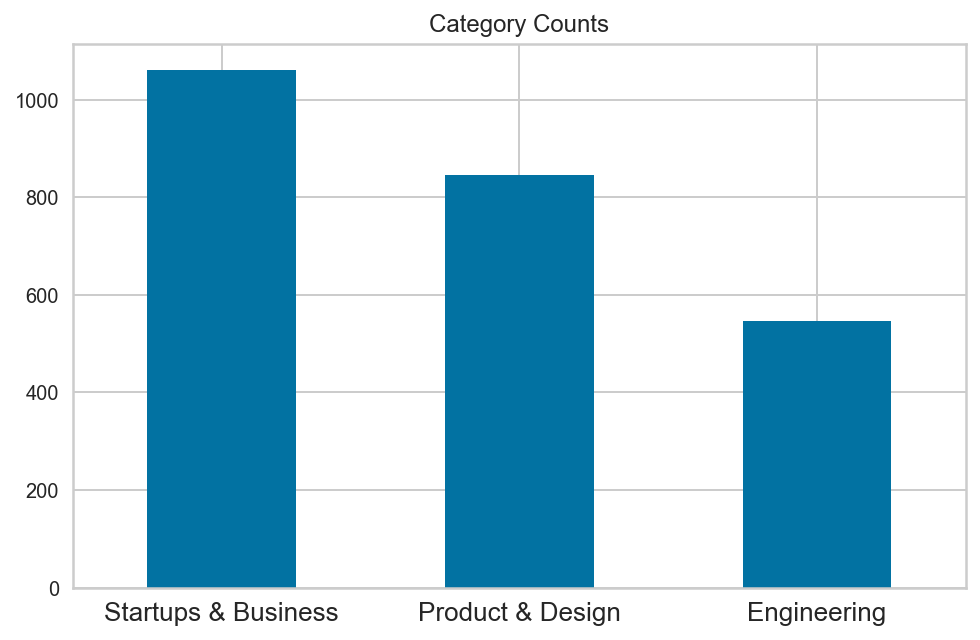

In [132]:
df.category.value_counts().plot(kind = 'bar', figsize = (8,5)  );
plt.title('Category Counts');
plt.xticks(rotation=0, size=13);

In [133]:
df.category.value_counts()

Startups & Business    1061
Product & Design        846
Engineering             547
Name: category, dtype: int64

<br>

**Add a Word Count Column**

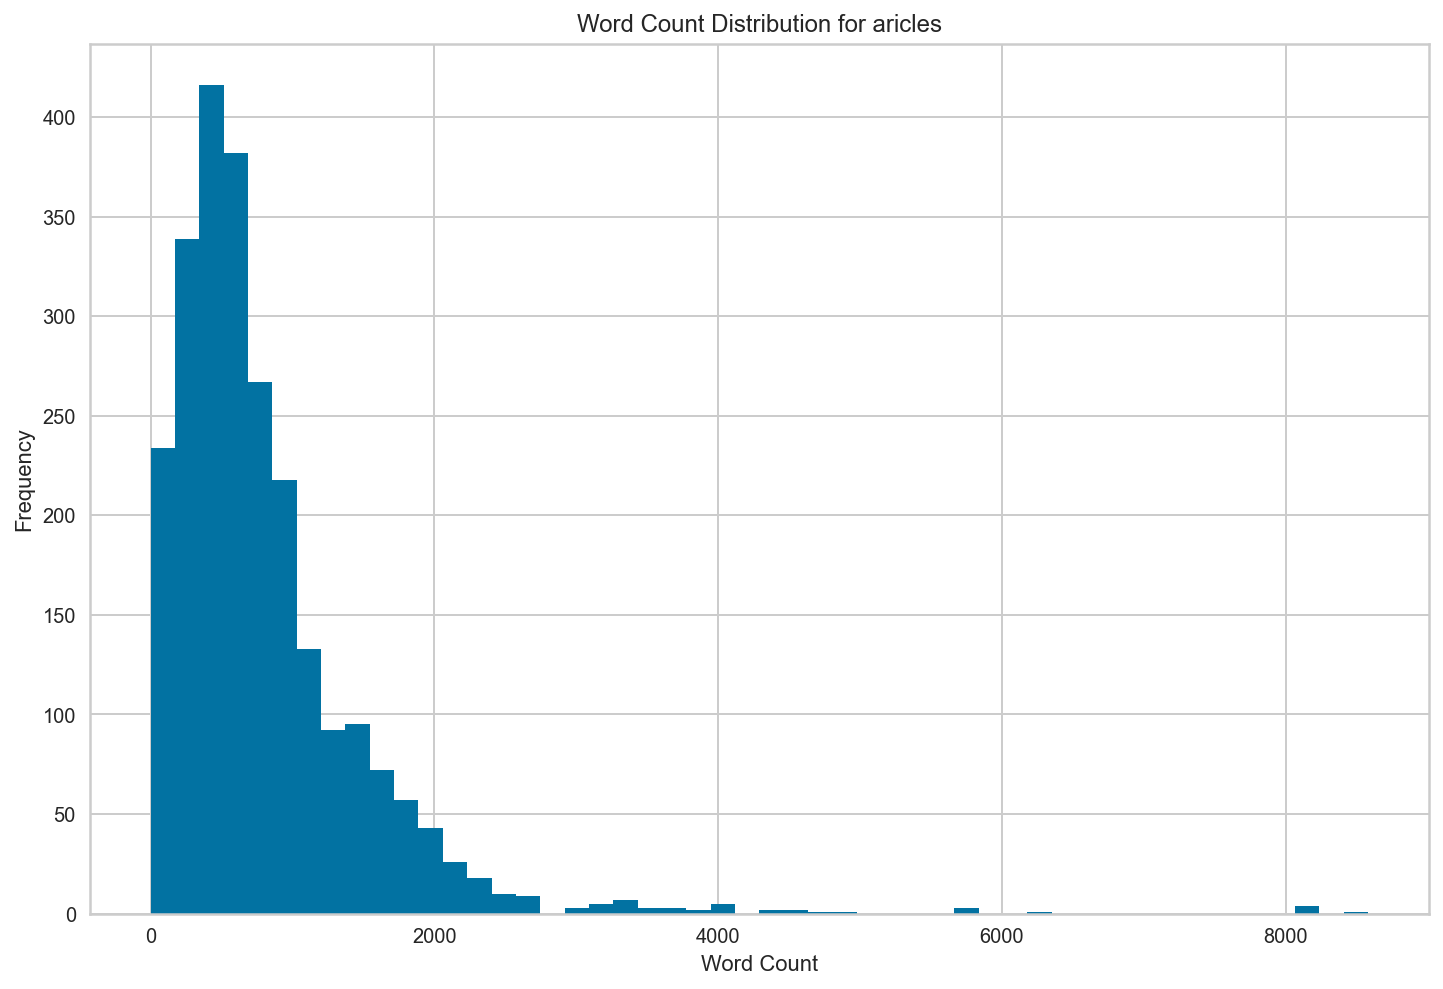

In [134]:
# Calculating the word count for articles
df['n_words'] = df['body_clean'].apply(lambda x: len(str(x).split()))# Plotting the word count
df['n_words'].plot(kind='hist', bins = 50, figsize = (12,8),
                   title='Word Count Distribution for aricles');
plt.xlabel('Word Count');

In [135]:
# Drop the words count column
df.drop(columns='n_words', inplace=True)

<br>

<a id='extract'></a>
## Step 1: Extract Features From Text
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract"><b>Step 1: Extract Features From Text</b></a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

https://www.geeksforgeeks.org/feature-extraction-techniques-nlp/ <br>
**https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76**

### Bag of Words:
I think this model will work well if we used only titles
- The BoW model is used in document classification, where each word is used as a feature for training the classifier. There are 3 steps while creating a BoW model :

    - **The first step** is text-preprocessing which involves: converting the entire text into lower case characters. removing all punctuations and unnecessary symbols.
    - **The second step** is to create a vocabulary of all unique words from the corpus. 
    - **In the third step**, we create a matrix of features by assigning a separate column for each word, while each row corresponds to a review. This process is known as Text Vectorization. Each entry in the matrix signifies the presence(or absence) of the word in the review. We put 1 if the word is present in the review, and 0 if it is not present.

<font color='red'> A major drawback in using this model is that the order of occurence of words is lost, as we create a vector of tokens in randomised order. However, we can solve this problem by considering N-grams (mostly bigrams) instead of individual words (i.e. unigrams). This can preserve local ordering of words. </font>

### N-grams (mostly bigrams)
- <font color='red'>However, this table will come out to be very large, as there can be a lot of possible bigrams by considering all possible consecutive word pairs. </font>
- <font color='red'>Also, using N-grams can result in a huge sparse(has a lot of 0’s) matrix, if the size of the vocabulary is large, making the computation really complex!! </font>
- **Thus, we have to remove a few N-grams based on their frequency.**
    - Like, we can always remove **high-frequency N-grams**, because they appear in almost all documents. These high-frequency N-grams are generally articles, determiners, etc. most commonly called as **StopWords**.
    - Similarly, we can also remove **low frequency N-grams** because these are really rare(i.e. generally appear in 1 or 2 reviews)!! These types of N-grams are generally **typos** (or typing mistakes).
- Generally, medium frequency N-grams are considered as the most ideal.
- However, there are some N-grams which are really rare in our corpus but can highlight a specific issue.
    - Review: “Wi-Fi breaks often”.
    - Here, the N-gram ‘Wi-Fi breaks can’t be too frequent, but it highlights a major problem that needs to be looked upon.
    
<font color='red'>Our BoW model would not capture such N-grams since its frequency is really low. To solve this type of problem, we need another model i.e. TF-IDF Vectorizer, which we will study next. </font>

### TF-IDF Vectorizer : 
I think this would be the best method if we used the body and not the titles
- TF-IDF stands for term frequency-inverse document frequency.
- **It highlights a specific issue which might not be too frequent in our corpus but holds great importance.** 
- The TF–IFD value **increases** proportionally to the number of times a word appears in the document 
- and **decreases** with the number of documents in the corpus that contain the word. It is composed of 2 sub-parts, which are :
    - Term Frequency (TF)
    - Inverse Document Frequency (IDF)

### TF-IDF Vectorizer : 
I think this would be the best method if we used the body and not the titles

https://stackoverflow.com/questions/34725726/is-it-possible-apply-pca-on-any-text-classification

In [136]:
# calculating tf-idf values
from sklearn.feature_extraction.text import TfidfVectorizer  

# (1, 2) means unigrams and bigrams
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df = 1, stop_words='english')
features = tfidf.fit_transform(df.title_clean)
  
df_features = pd.DataFrame(features.todense(), columns = tfidf.get_feature_names_out())   
print(df_features.shape)
df_features.head()

(2454, 10940)


,aarron,aarron walter,able,able tell,abstraction,abstraction abundance,abstractions,abstractions role,abstractive,abstractive summarization,...,zillow good,zola,zola cherishes,zombie,zombie apocalypse,zones,zones tools,zuckerberg,zuul,zuul netflix
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
# df_features[(df_features != 0).any(axis=1)]

In [138]:
# 'your' in df_features.columns

<br>

### Bag of Words : 
I think this model will work well if we used only titles

In [139]:
# # Implementing Bag of Words in scikit-learn

# from sklearn.feature_extraction.text import CountVectorizer

# t0 = time()
# count_vector = CountVectorizer(stop_words='english')
# features_array = count_vector.fit_transform(df.title_clean).toarray()
# frequency_matrix = pd.DataFrame(features_array, columns=count_vector.get_feature_names())
# print(time()-t0)
# print(frequency_matrix.shape)
# frequency_matrix.head()

In [140]:
# 'your' in frequency_matrix.columns

In [141]:
# '"' in frequency_matrix.columns

In [142]:
# nltk.word_tokenize('01 margo to market fit: achieving sustainable growth')

In [143]:
# # Implementing Bag of Words Manually
# # By creating a list of dictionaries with words and their counts in each text

# def bag_of_words(text):
#     word2count = {}
#     words = nltk.word_tokenize(text) 
#     for word in words: 
#         if word not in word2count.keys(): 
#             word2count[word] = 1
#         else: 
#             word2count[word] += 1
            
#     return word2count

In [144]:
# dict_list = []
# for text in df.title:
#     dict_list.append(bag_of_words(text))

# frequency_matrix = pd.DataFrame(dict_list) 
# frequency_matrix.fillna(0, inplace=True)
# print(frequency_matrix.shape)
# frequency_matrix.head()

In [145]:
# frequency_matrix[(frequency_matrix != 0).any(axis=1)]

In [146]:
# 'your' in frequency_matrix.columns

<br>

**Drop StopWords, numeric, and not-alpha Columns**

**There are two methods:**
- We can add a clean_text column in the data, then use string methods --> **DONE**
- or we can extract features, then drop the unwanted columns

In [147]:
# columns_to_drop = []
# for col in frequency_matrix.columns:
#     if col in stop_words:
#         columns_to_drop.append(col)
#     if not col.isalpha():
#         columns_to_drop.append(col)
        
# len(columns_to_drop)

In [148]:
# frequency_matrix.drop(columns=columns_to_drop, inplace=True)
# print(frequency_matrix.shape)
# frequency_matrix.head(1)

<br>

<a id='reduce'></a>
## Step 2:  Dimensionality Reduction
1. Feature Selection
2. Feature Extraction (PCA) 

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce"><b>Step 2: Dimensionality Reduction</b></a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

## 1. Feature Selection

**Drop Correlated Columns** <br>
https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [149]:
# Identify correlations between numeric features
t0 = time()
columns_to_drop = helper.get_correlated_columns(df_features, 0.95)
print(time()-t0)
print(len(columns_to_drop))
# columns_to_drop

611.881135225296
6857


In [150]:
X = df_features.drop(columns=columns_to_drop)
print(X.shape)
X.head(1)

(2454, 4083)


,aarron,able,abstraction,abstractions,abstractive,abuse,academia,accelerate,accelerates,accelerator,...,writer,writing,wrong,wrong right,year,years,york,zapier,zero,zero million
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
# X = df_features.copy()
X.columns[:100]

Index(['aarron', 'able', 'abstraction', 'abstractions', 'abstractive', 'abuse',
       'academia', 'accelerate', 'accelerates', 'accelerator',
       'accelerator needs', 'acceptance', 'access', 'accessibility',
       'accessible', 'accessible android', 'accessible matters', 'accident',
       'accomplishing', 'according', 'according adeo', 'according experts',
       'according runs', 'account', 'accounting', 'accounting revenue',
       'accounting user', 'accurate', 'achieve', 'achieved',
       'achieved product', 'achieved rate', 'achieving', 'achieving product',
       'achieving sustainable', 'acing', 'acoustic', 'acquire',
       'acquire reactivate', 'acquire retain', 'acquired', 'acquiring',
       'acquisition', 'acquisition easy', 'acquisition expert',
       'acquisition great', 'acquisition kill', 'acquisition strategies',
       'action', 'action examples', 'action perfection', 'actionable',
       'actionable fine', 'actionable ways', 'actions', 'activation',
       'a

> **NOTE:**
>- I wanted to keep columns which contain alphanumeric, I believed some of them would be helpful in the clustering,
> - But, I decided to remove them since they contained a lot of misleading features

In [23]:
# # Drop Numeric Columns
# columns_to_drop = []
# for col in X.columns:
#     if col.isdigit():
#         columns_to_drop.append(col)
        
# print(len(columns_to_drop))

In [24]:
# X.drop(columns=columns_to_drop, inplace=True)
# print(X.shape)
# X.head(1)

In [25]:
y = df.category.map({'Engineering': 0, 'Product & Design': 1, 'Startups & Business':2})
len(y)

2454

<br>

**https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features**

## 2. Feature Extraction 
PCA --> Principal Component Analysis

**All Data (Without Separation)**

> **NOTE:**
> - <font color='red'> **Don't scale features after BOW or TF-IDF** </font>
> - <font color='red'> We scale features to make sure all of them are treated the same (to avoid bias), </font>
> - <font color='red'> as the model understand larger values as more importat, **which is actually the case here!** </font>
> - <font color='red'> BOW or TF-IDF give higher values to most repeated words, which are more important </font>

https://stats.stackexchange.com/questions/65047/normalizing-term-frequency-for-document-clustering

TF/IDF usually is a two-fold normalization.

First, each document is normalized to length 1, so there is no bias for longer or shorter documents. This equals taking the relative frequencies instead of the absolute term counts. This is "TF".

Second, IDF then is a cross-document normalization, that puts less weight on common terms, and more weight on rare terms, by normalizing (weighting) each word with the inverse in-corpus frequency. Here it does not matter whether you use the absolute or relative frequency, as this amounts just to a constant factor across all vectors, so you will get different distances, but only by a constant factor (the corpus size).




In [26]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(X)

# X_scaled = pd.DataFrame(data_scaled, columns=list(X.columns))
# print(X_scaled.shape)
# X_scaled.head()

In [27]:
# X_scaled.describe() #Mean=0, Std=1

In [28]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X) # Don't scale features after bow or tf-idf

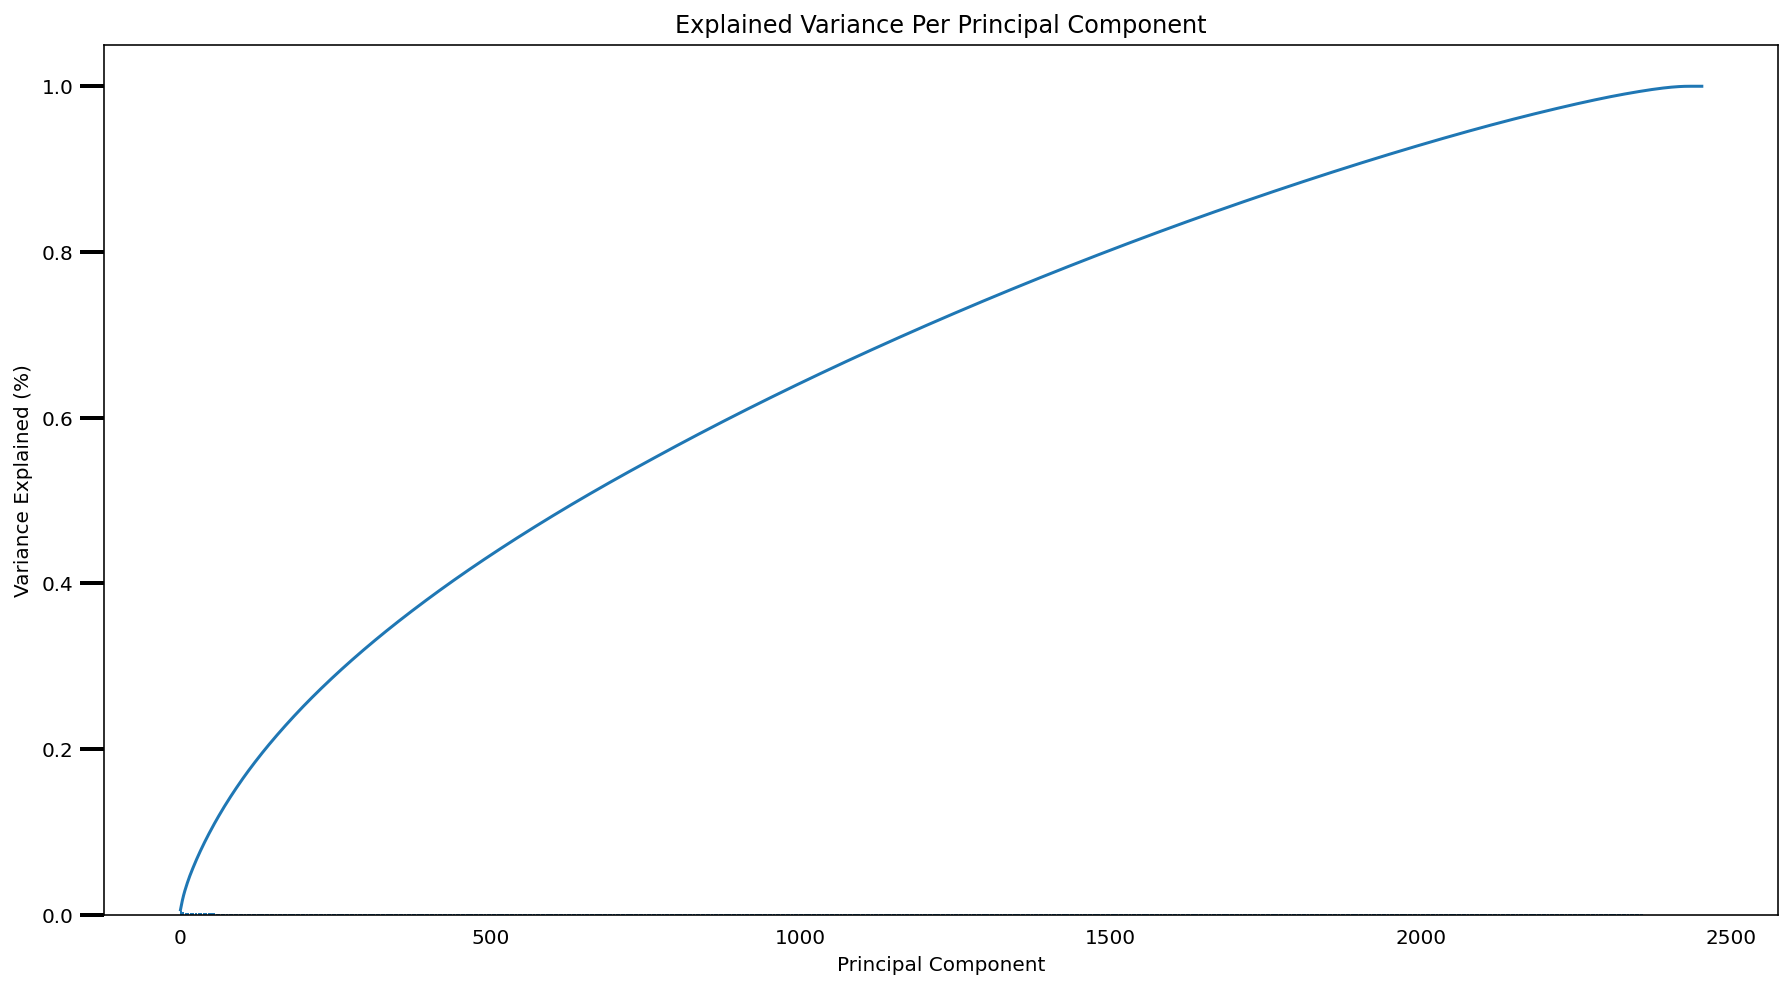

In [29]:
# To get the number of pca components to use (highest variance)
helper.scree_plot(pca)

In [30]:
# Re-apply PCA to the data while selecting for number of components to retain.

num_components=len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_

cumvals = np.cumsum(vals)
ind = next(x[0] for x in enumerate(cumvals) if x[1] > 0.8)
num_comps = ind+1
num_comps

print(f'{num_comps} PCA components --> allow us to capture {round(cumvals[num_comps-1]*100,2)}% of data variability')

1493 PCA components --> allow us to capture 80.0% of data variability


In [31]:
pca = PCA(n_components=num_comps)
X_pca = pca.fit_transform(X)

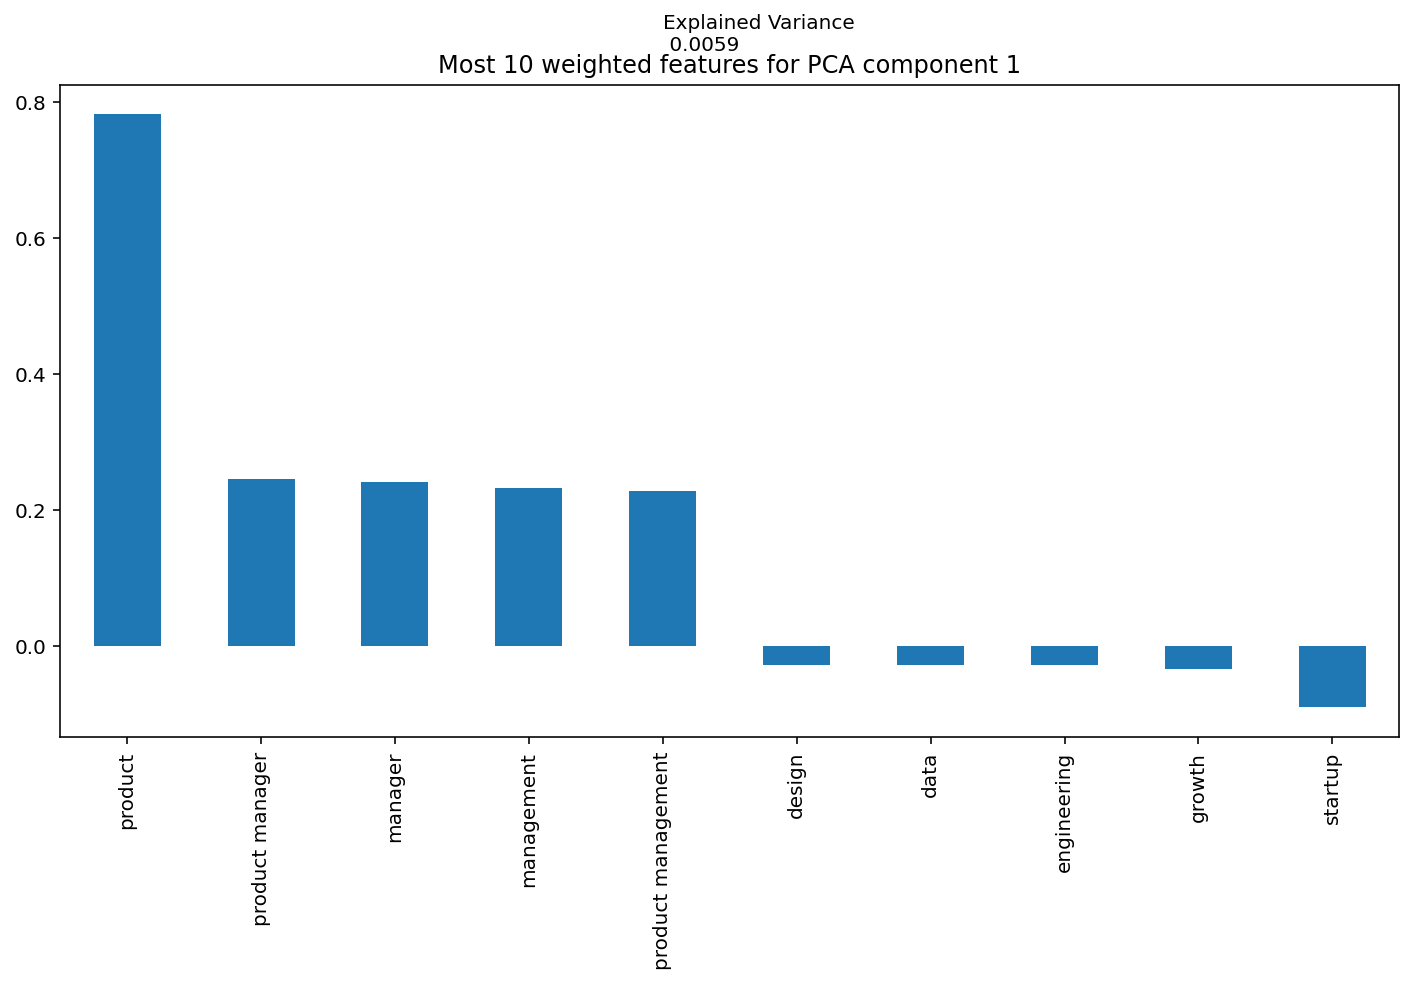

product               0.7819
product manager       0.2447
manager               0.2416
management            0.2324
product management    0.2277
design               -0.0279
data                 -0.0281
engineering          -0.0287
growth               -0.0346
startup              -0.0909
Name: 0, dtype: float64


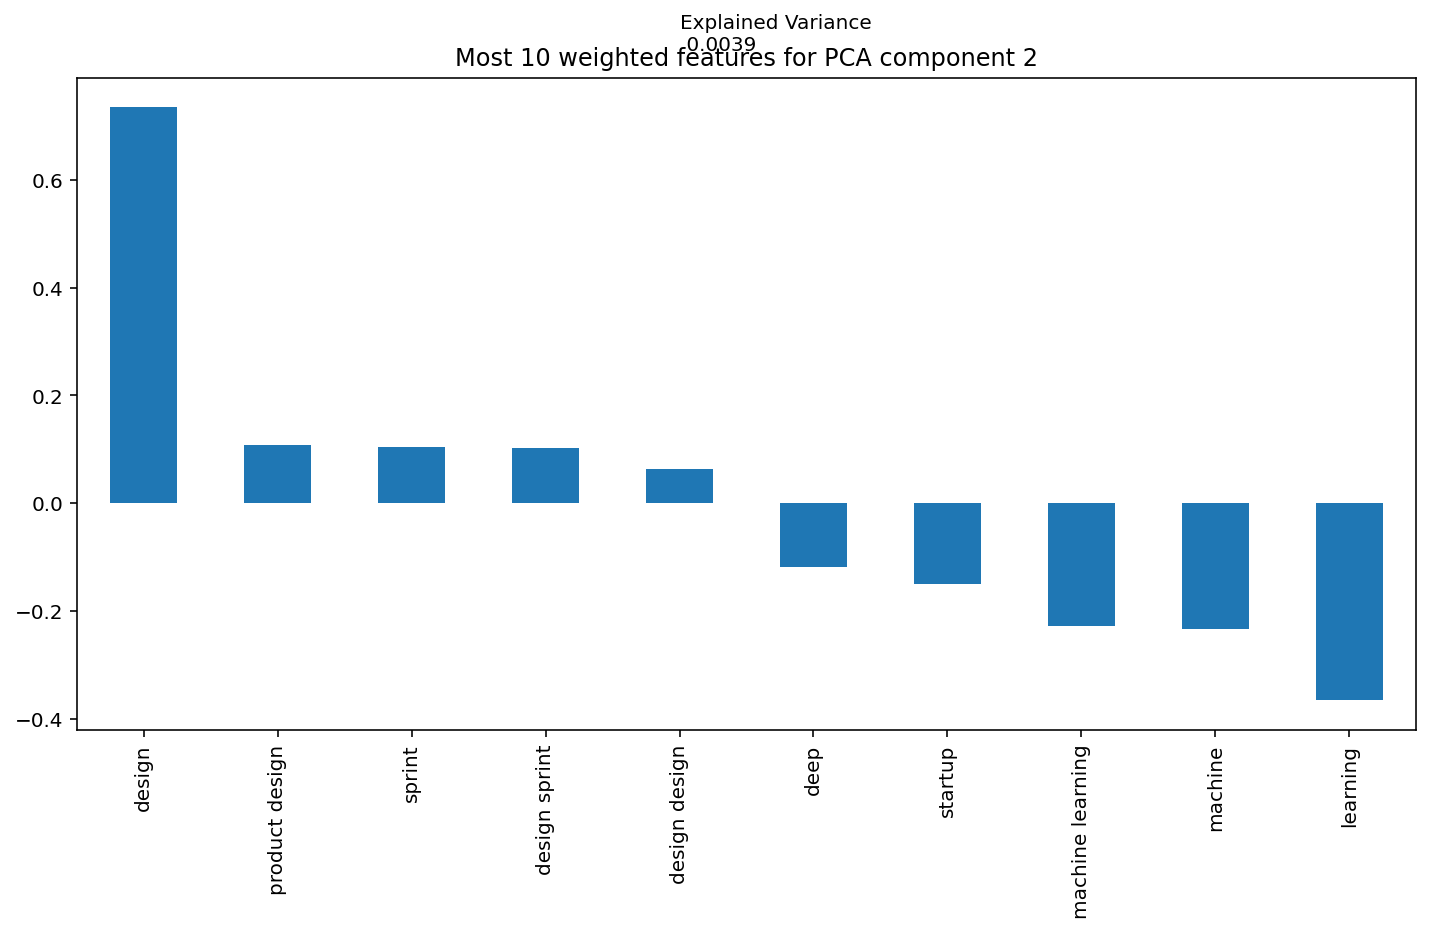

design              0.7347
product design      0.1082
sprint              0.1041
design sprint       0.1015
design design       0.0636
deep               -0.1188
startup            -0.1506
machine learning   -0.2281
machine            -0.2341
learning           -0.3656
Name: 1, dtype: float64


In [32]:
# Interpret Principal Components

res = helper.pca_results(X, pca, 1, 5)
print(res)

res = helper.pca_results(X, pca, 2, 5)
print(res)

<br>

https://stats.stackexchange.com/questions/363024/unsupervised-classification-vs-supervised-classification-when-data-labels-are-kn <br>
**https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features**

<a id='supervised'></a>
## Step 3: Build a Supervised Learning Model (Classifier)

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised"><b>Step 3: Build a Supervised Learning Model</b></a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

> The accuracy score seems to be a good metric for this problem,
> as it's not critical if we misclassified an article.

In [33]:
# # Default XGBClassifier

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=100, n_jobs=12, num_parallel_tree=1,
#               objective='multi:softprob', random_state=0, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=None, subsample=1,
#               tree_method='exact', use_label_encoder=False,
#               validate_parameters=1, verbosity=None)

In [34]:
### Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
from xgboost import XGBClassifier

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [36]:
t0 = time()
# build a classifier
clf_xgb = XGBClassifier(n_estimators=220, random_state=42)
clf_xgb.fit(X_train, y_train)
xgb_preds = clf_xgb.predict(X_test)

helper.print_metrics(y_test, xgb_preds, 'XGBClassifier')
print(time()-t0)

Accuracy score for XGBClassifier : 0.745417515274949
110.083575963974


In [37]:
t0 = time()
# build a classifier
clf_rf = RandomForestClassifier(n_estimators=200, random_state=42) # default --> n_estimators=100
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

helper.print_metrics(y_test, rf_preds, 'RandomForestClassifier')
print(time()-t0)

Accuracy score for RandomForestClassifier : 0.7067209775967414
8.459334135055542


**Without PCA**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# t0 = time()
# # build a classifier
# clf_xgb = XGBClassifier(n_estimators=220, random_state=42) # default --> n_estimators=100
# clf_xgb.fit(X_train, y_train)
# xgb_preds = clf_xgb.predict(X_test)

# helper.print_metrics(y_test, xgb_preds, 'XGBClassifier')
# print(time()-t0)

In [40]:
t0 = time()
# build a classifier
clf_rf = RandomForestClassifier(n_estimators=220, random_state=42) # default --> n_estimators=100
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

helper.print_metrics(y_test, rf_preds, 'RandomForestClassifier')
print(time()-t0) 

Accuracy score for RandomForestClassifier : 0.7393075356415478
13.987661123275757


**Model Tuning**

In [41]:
# start = time()
# # Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
# from sklearn.model_selection import GridSearchCV 
# from sklearn.metrics import make_scorer
# from sklearn.metrics import accuracy_score

# # Initialize the classifier
# clf = RandomForestClassifier() # default --> n_estimators=100

# # Create the parameters list you wish to tune, using a dictionary if needed.
# # HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
# parameters = {
# #     "max_depth": [3,5,8,10,None],
#     "n_estimators": [200, 220, 250],
# #     "max_features":["log2","sqrt", None],
# #     "min_samples_split": list(range(2, 11)),
# #     "min_samples_leaf": list(range(1, 11)), 
# #     "learning_rate": [0.01, 0.05, 0.1],
#     }

# # Make an fbeta_score scoring object using make_scorer()
# scorer = make_scorer(accuracy_score)

# # Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
# grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# # Fit the grid search object to the training data and find the optimal parameters using fit()
# grid_fit = grid_obj.fit(X_train, y_train)

# # Get the estimator
# best_clf = grid_fit.best_estimator_

# # Make predictions using the unoptimized and model
# predictions = (clf.fit(X_train, y_train)).predict(X_test)
# best_predictions = best_clf.predict(X_test)

# # Report the before-and-afterscores
# print("Unoptimized model\n------")
# print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
# print("\nOptimized Model\n------")
# print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
# (time() - start) / 60

In [42]:
# best_clf

<br>

https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features

<a id='cluster'></a>
## Step 3: Filter & Cluster

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster"><b>Step 4: Filter & Cluster</b></a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

><ul>
 <li><a href="#eng">Engineering</a></li>
 <li><a href="#product">Product & Design</a></li>
 <li><a href="#business">Startups & Business</a></li>
 </ul>

In [43]:
df.category.value_counts()

Startups & Business    1061
Product & Design        846
Engineering             547
Name: category, dtype: int64

In [44]:
print('category' in X.columns)
'article_category' in X.columns

True


False

In [152]:
# X.drop(columns='article_category', inplace=True)

In [153]:
# Add the category column to use in filtering
X_to_filter = X.copy()
X_to_filter.insert(0, 'article_category', df.category)
X_to_filter.head(1)

,article_category,aarron,able,abstraction,abstractions,abstractive,abuse,academia,accelerate,accelerates,...,writer,writing,wrong,wrong right,year,years,york,zapier,zero,zero million
0,Startups & Business,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='eng'></a> 
### Feature Extraction (Engineering)
<ul>
<li><a href="#eng"><b>Engineering</b></a></li>
<li><a href="#product">Product & Design</a></li>
<li><a href="#business">Startups & Business</a></li>
</ul>

> **NOTE:**
> - Before we scale data and apply Feature Extraction, we will separate the articles by category.

In [154]:
df_eng = X_to_filter.query(" article_category == 'Engineering'")
X_eng = df_eng.iloc[:, 1:]
X_eng.reset_index(inplace=True, drop=True)
print(X_eng.shape)
X_eng.head(3)

(547, 4083)


,aarron,able,abstraction,abstractions,abstractive,abuse,academia,accelerate,accelerates,accelerator,...,writer,writing,wrong,wrong right,year,years,york,zapier,zero,zero million
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_eng_scaled = scaler.fit_transform(X_engineering) #Mean=0, Std=1

# X_eng_scaled = pd.DataFrame(data_eng_scaled, columns=list(X_engineering.columns))
# print(X_eng_scaled.shape)
# X_eng_scaled.head(1)

In [156]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_eng_pca = pca.fit_transform(X_eng)

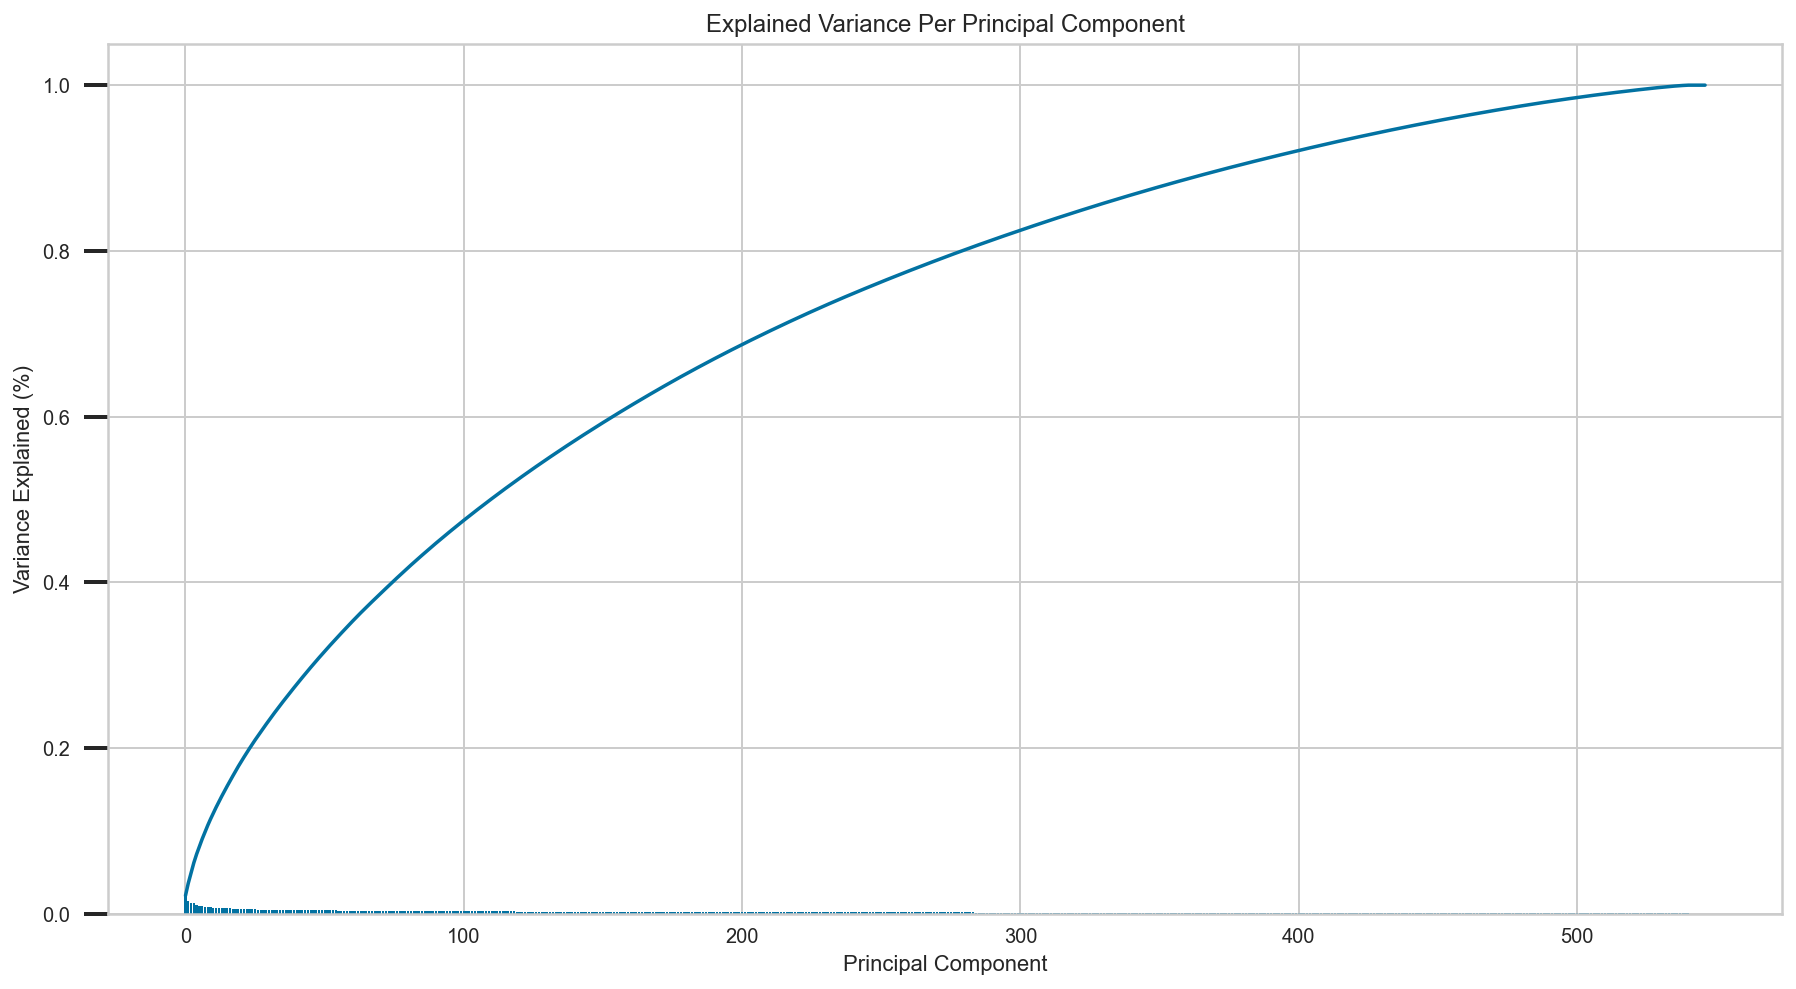

In [157]:
# To get the number of pca components to use (highest variance)
helper.scree_plot(pca)

In [158]:
# Re-apply PCA to the data while selecting for number of components to retain.

num_components=len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_

cumvals = np.cumsum(vals)
ind = next(x[0] for x in enumerate(cumvals) if x[1] > 0.8)
num_comps = ind+1
num_comps

print(f'{num_comps} PCA components --> allow us to capture {round(cumvals[num_comps-1]*100,2)}% of data variability')

281 PCA components --> allow us to capture 80.12% of data variability


In [159]:
pca = PCA(n_components=num_comps)
X_eng_pca = pca.fit_transform(X_eng)

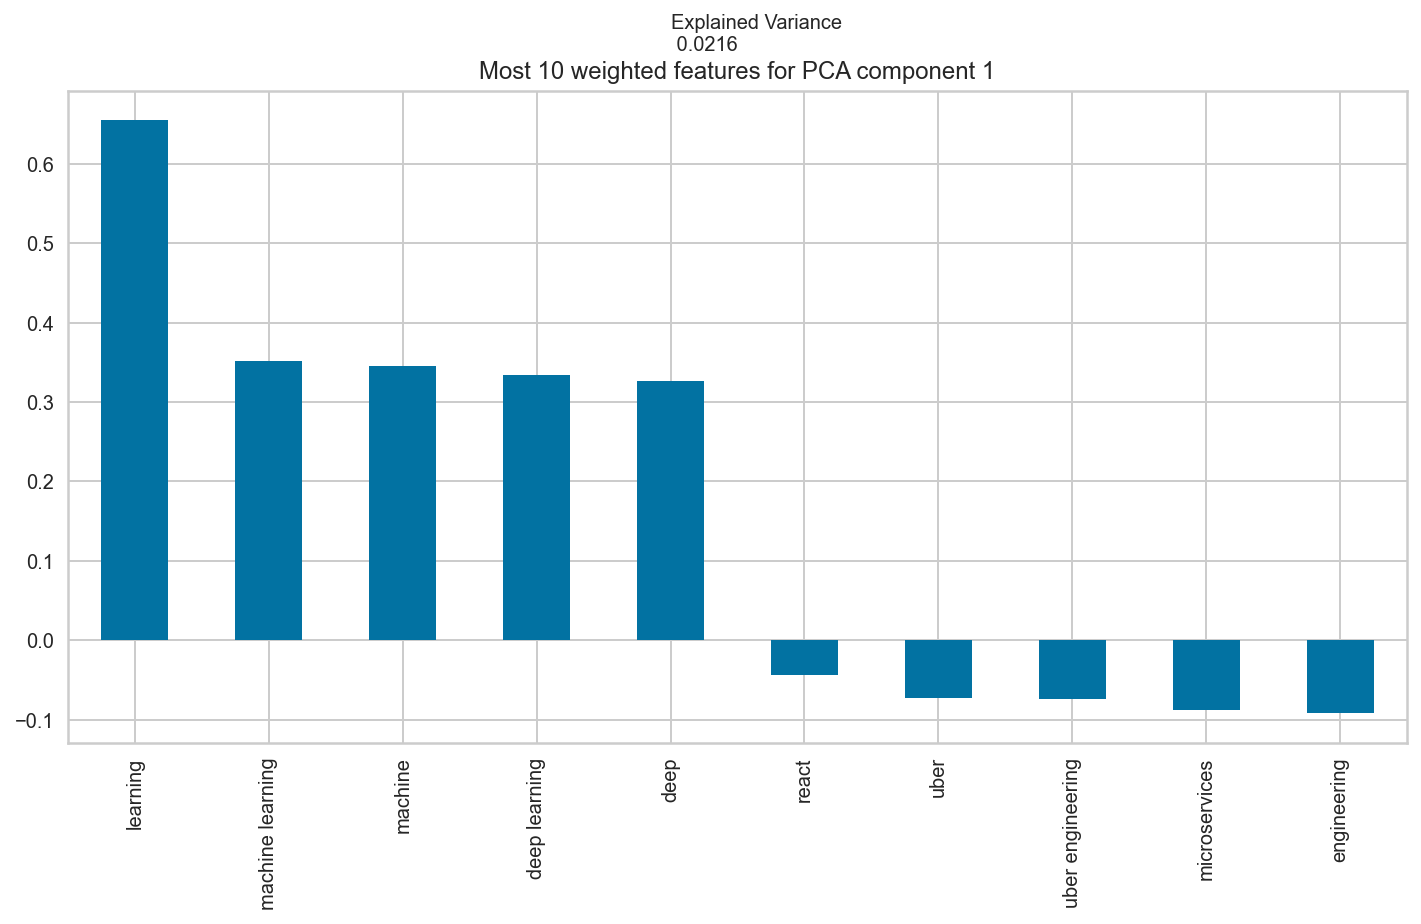

learning            0.6547
machine learning    0.3519
machine             0.3450
deep learning       0.3334
deep                0.3264
react              -0.0439
uber               -0.0726
uber engineering   -0.0735
microservices      -0.0875
engineering        -0.0921
Name: 0, dtype: float64


In [160]:
# Interpret Principal Components

# # Check first 3 components
# for i in np.arange(0, 3, 1):
#     res = pca_results(azdias_clean_scaled, pca, i, 5)
#     print(res)

res = helper.pca_results(X_eng, pca, 1, 5)
print(res)

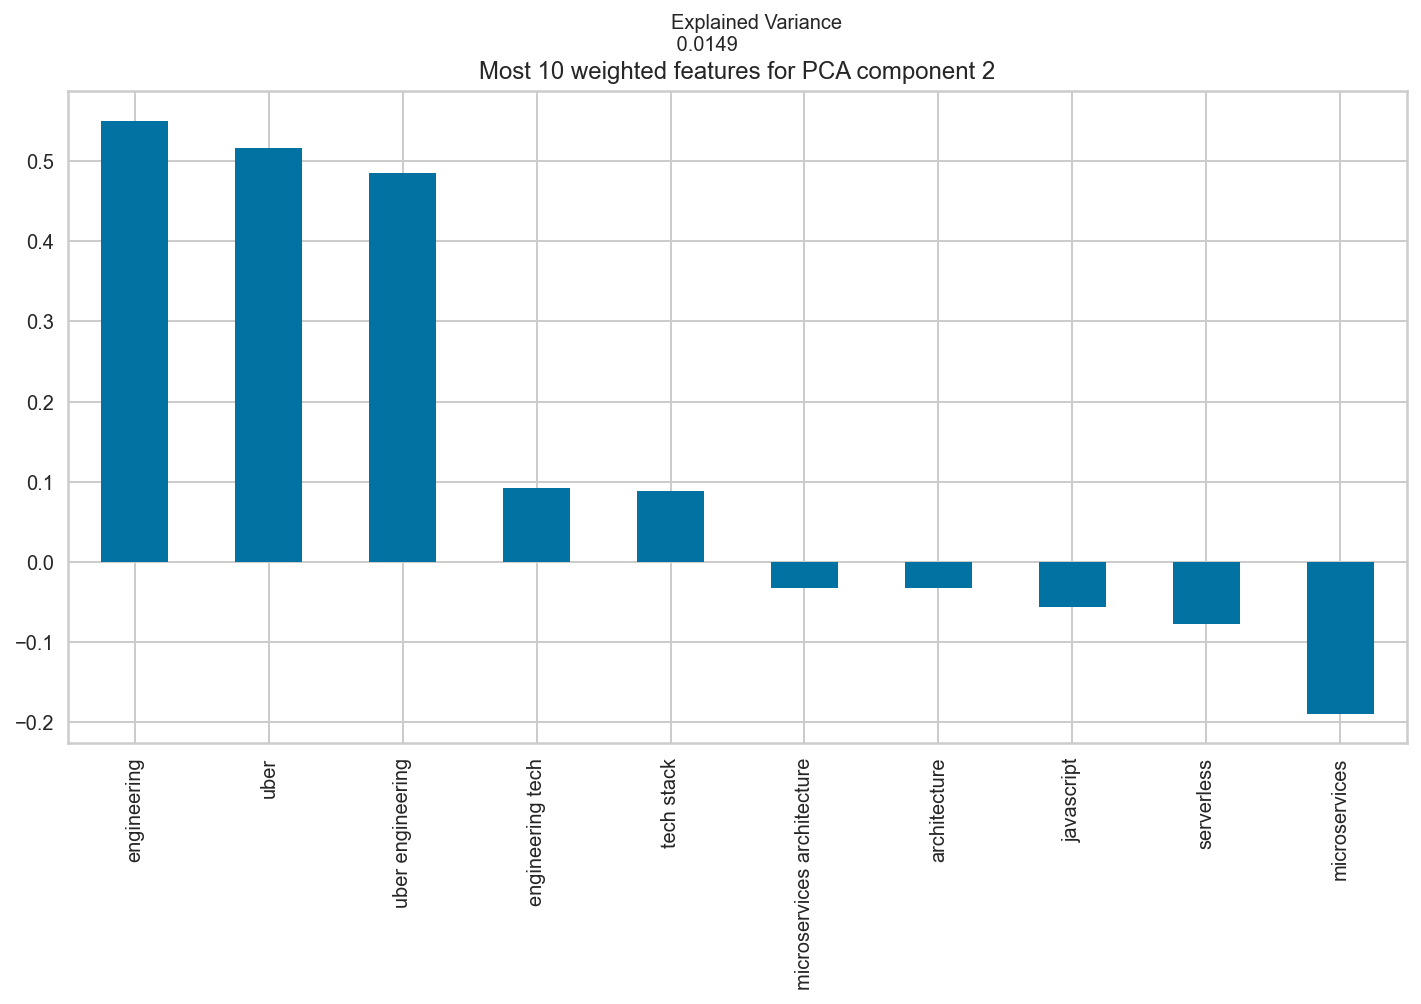

engineering                   0.5506
uber                          0.5159
uber engineering              0.4849
engineering tech              0.0916
tech stack                    0.0882
microservices architecture   -0.0321
architecture                 -0.0325
javascript                   -0.0564
serverless                   -0.0774
microservices                -0.1894
Name: 1, dtype: float64


In [161]:
res = helper.pca_results(X_eng, pca, 2, 5)
print(res)

<br>

https://www.quora.com/What-is-the-most-used-algorithm-for-text-documents-clustering <br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8125674/

## Clustering (Engineering)
- For now, we will use kmeans "the most used clustering algorithm".
- But, we can try other clustering algorithms later.
- If the data is **text-based** the **proximity measure** should be set to **cosine distance**, instead of, euclidian distance.  
- However, this is not the case for kmeans:
- https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric

In [162]:
# # Create a toy dataset to reduce computation time
# # Reduce the size to 25%
# X_pca_sample = X_pca[np.random.choice(X_pca.shape[0], int(df.shape[0]*0.25), replace=False)]

In [163]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
t0 = time()

sse = [] # Sum of Squared Errors
silhouette = []
calinski = []
k_range = np.arange(2, 21)

for k in k_range:
    kmeans = KMeans(k, random_state=42) # , max_iter=30
    model = kmeans.fit(X_eng)
    preds = model.predict(X_eng)
    # Scoring
    sil_score = silhouette_score(X_eng, preds) #, metric='cosine'
    calinski_score = calinski_harabasz_score(X_eng, preds)
    score = np.abs(model.score(X_eng))
    sse.append(score)
    silhouette.append(sil_score)
    calinski.append(calinski_score)
    
#     # Print Results
#     print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))
#     print("For n_clusters = {}, silhouette score is {})".format(k, round(sil_score, 2)))
#     print("For n_clusters = {}, calinski_harabasz score is {})".format(k, round(calinski_score, 2)))
#     print('-'*50)
    
   
print((time()-t0)/60)

0.20692243178685507


<br>

### K Clusters 

https://vitalflux.com/elbow-method-silhouette-score-which-better/

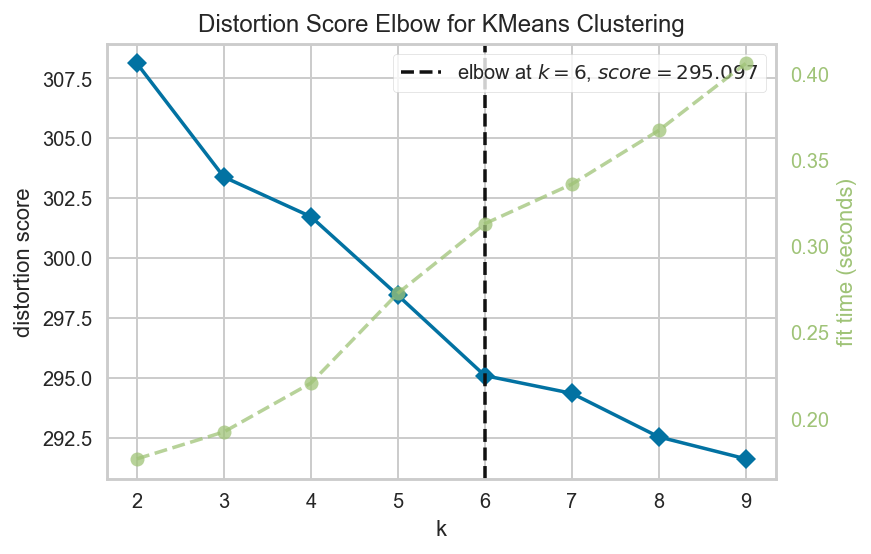

In [164]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
visualizer.fit(X_eng);        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

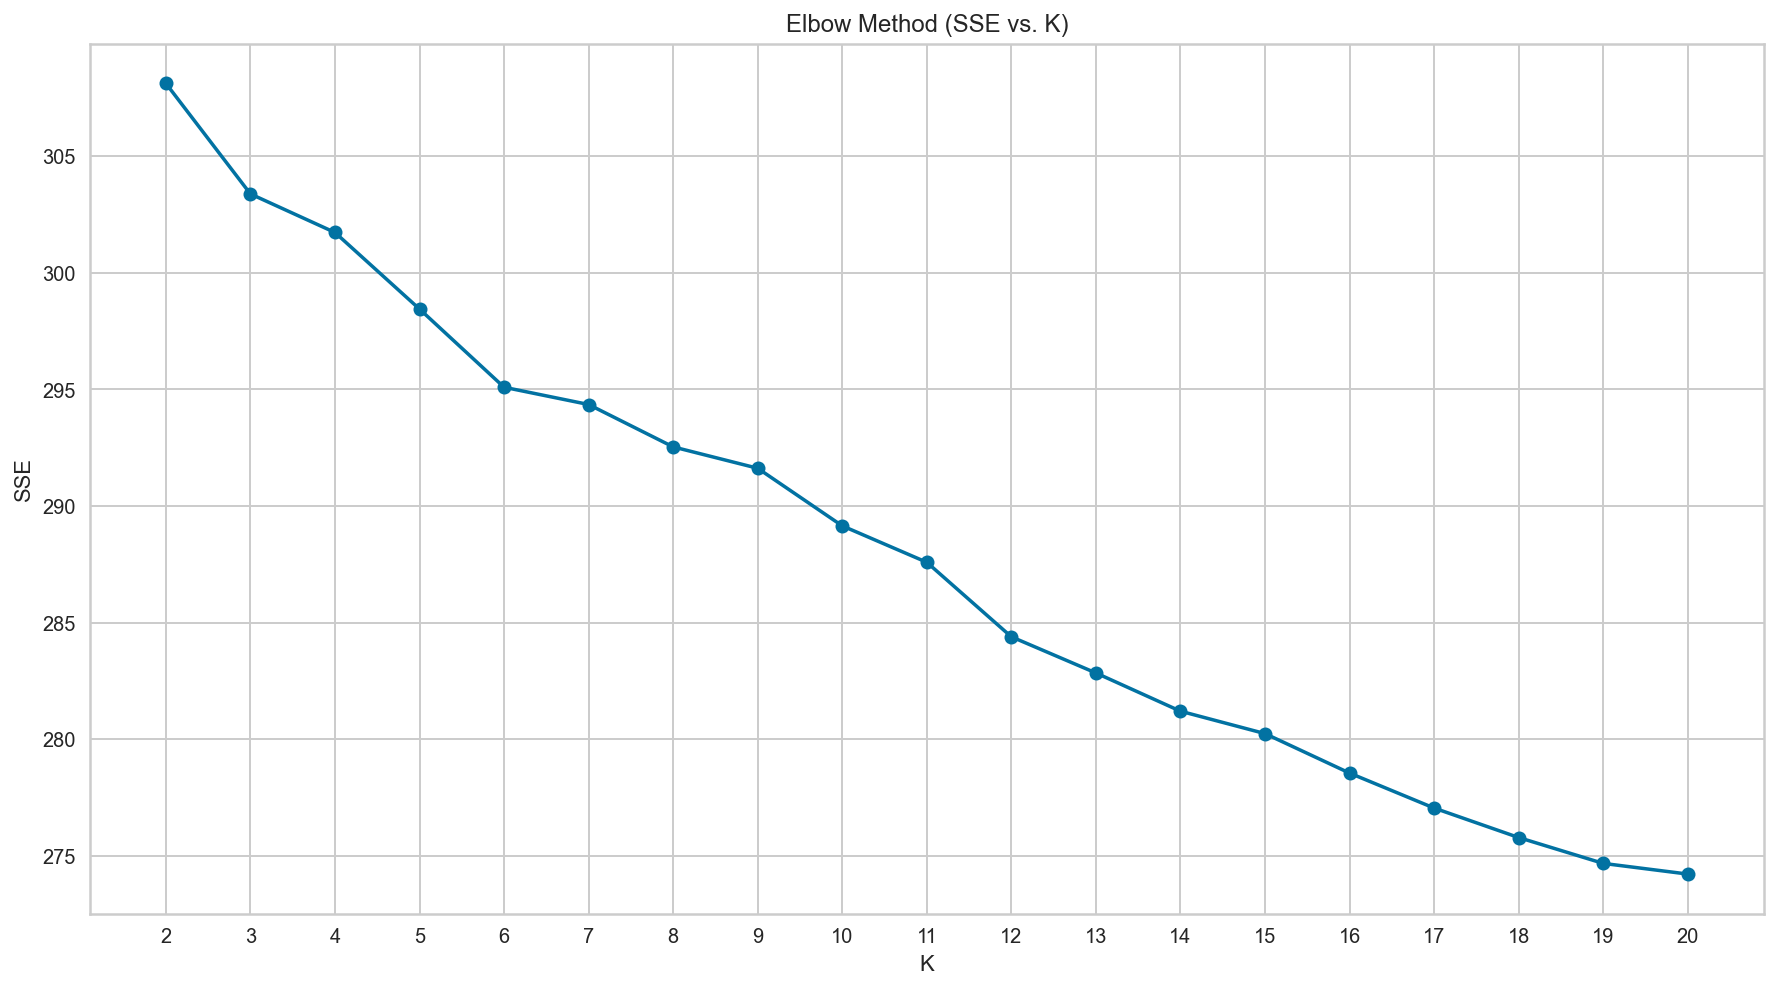

In [165]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

> **NOTE:**
> - we can not see a clear elbow, but we are going to use 4 clusters as given (prior knowledge),
> - And will validate with Silhouette Score

## Clustering Validation (Engineering)

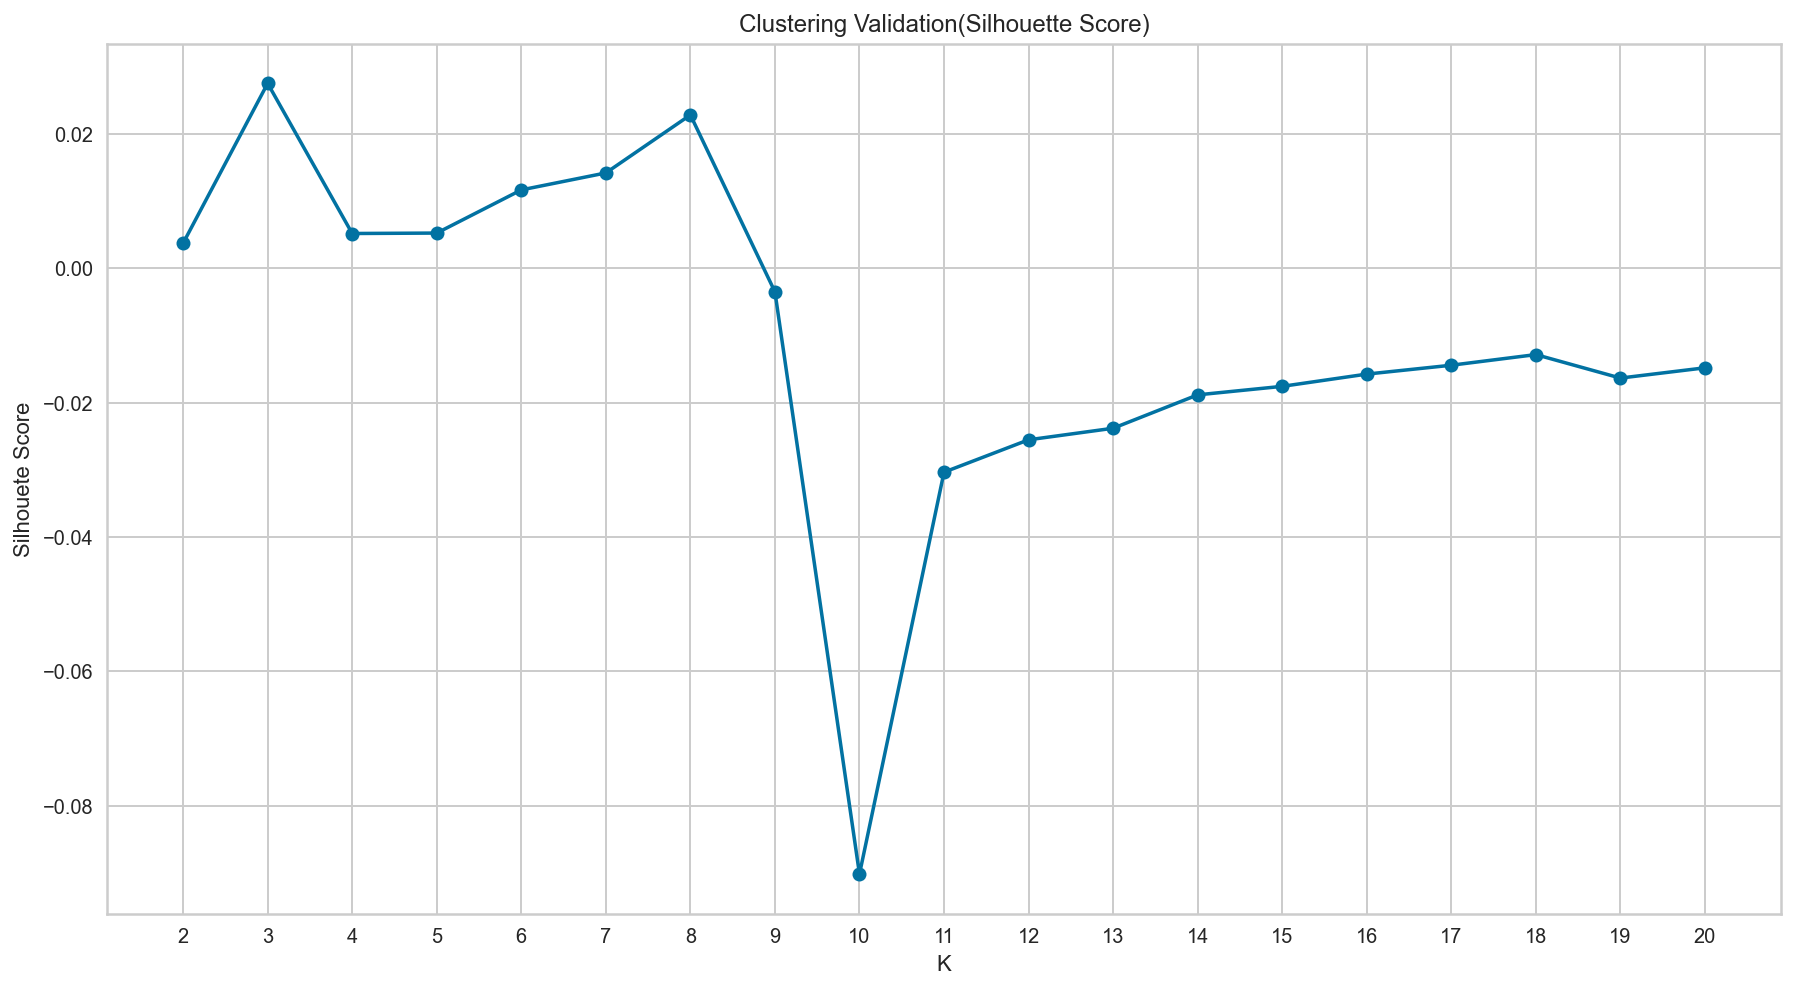

In [166]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('Silhouete Score')
plt.title('Clustering Validation(Silhouette Score)')
plt.plot(k_range, silhouette, linestyle='-', marker='o');

> **NOTE:**
> - Silhouette Score suggests k=3, but we are going to use 4 clusters as given (prior knowledge).

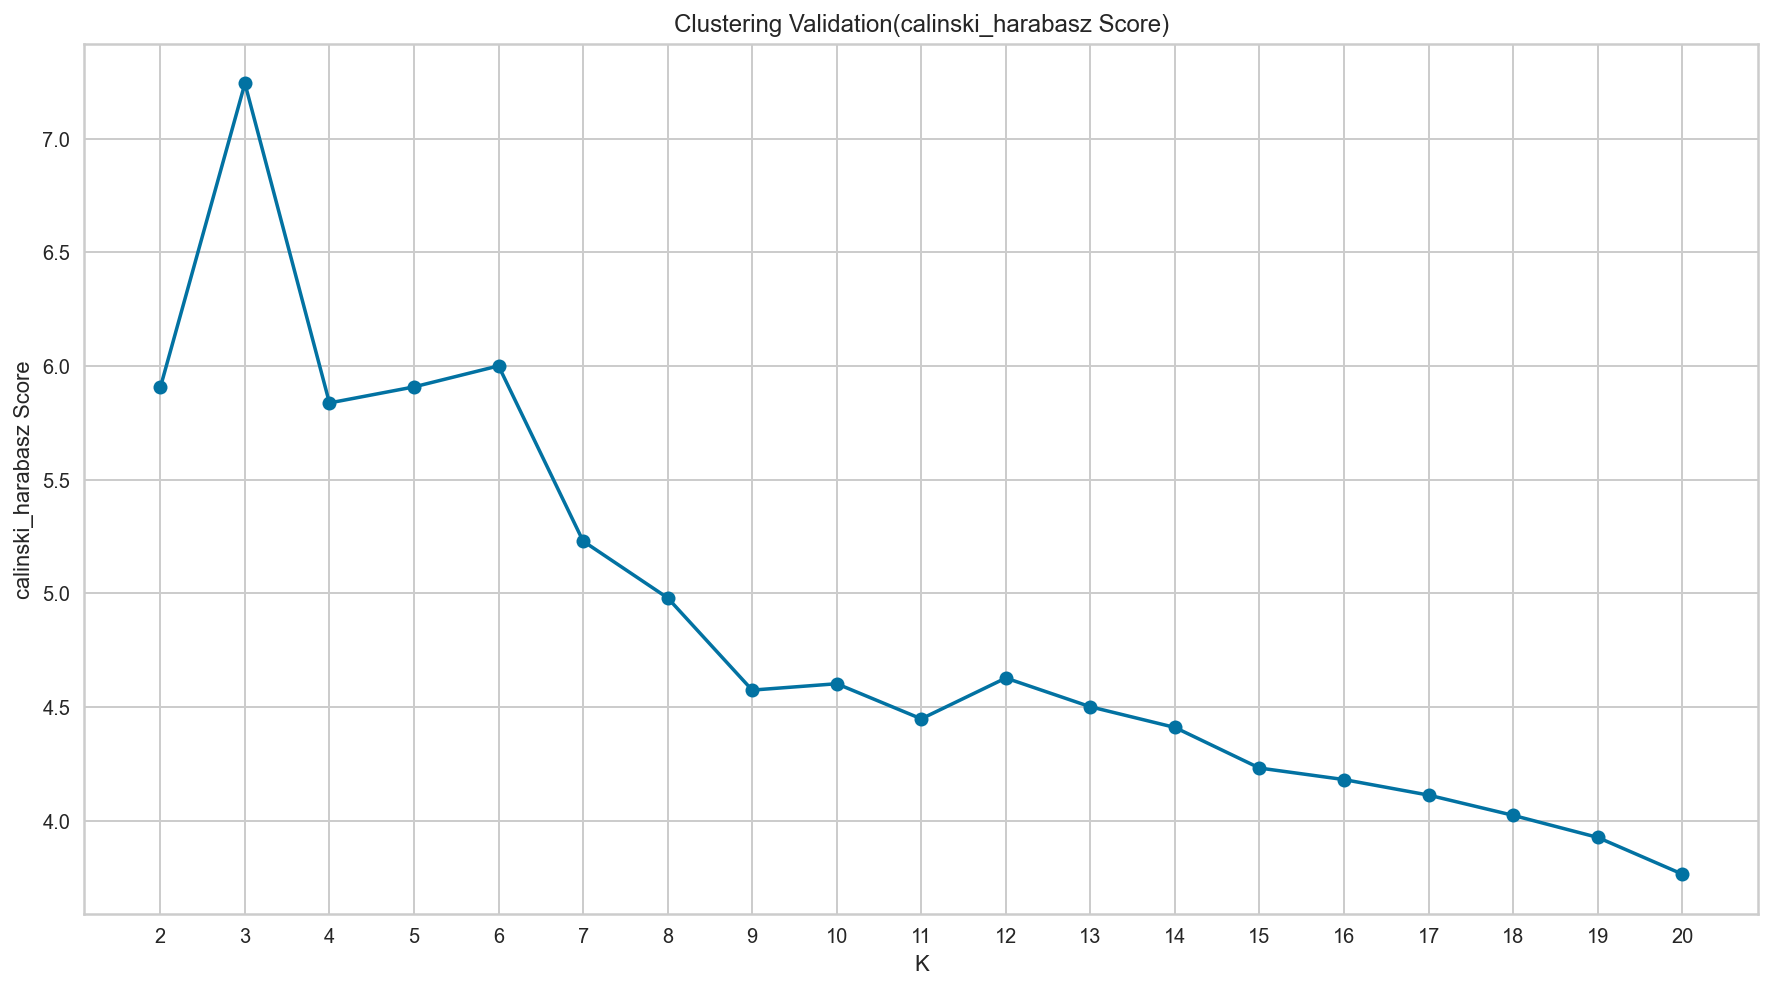

In [167]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('calinski_harabasz Score')
plt.title('Clustering Validation(calinski_harabasz Score)')
plt.plot(k_range, calinski, linestyle='-', marker='o');

> **NOTE:**
> - calinski_harabasz Score suggests k=3, but we are going to use 4 clusters as given (prior knowledge).

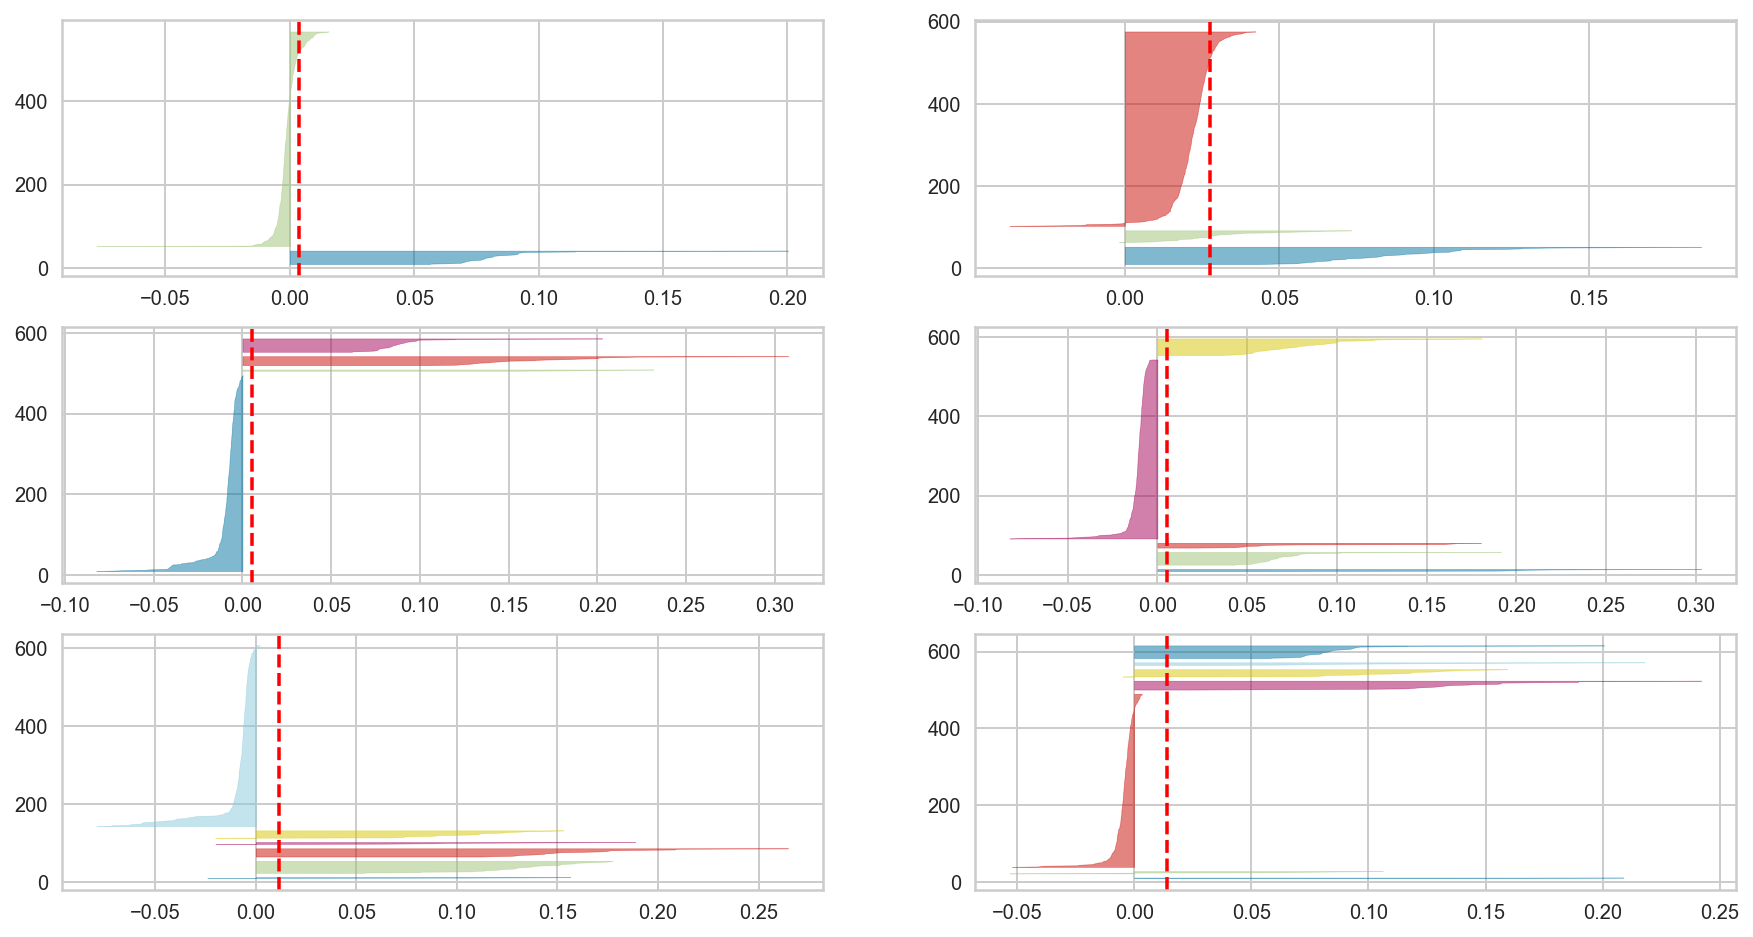

In [168]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_eng) 

In [169]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_4 = KMeans(n_clusters=4, random_state=42)
model_eng = kmeans_4.fit(X_eng)
clusters_eng = model_eng.predict(X_eng)

print(time()-t0)

0.307157039642334


In [170]:
clusters_eng 

array([0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 2, 2, 0, 0, 0, 3, 0, 0, 0, 2, 0, 1, 3, 3,

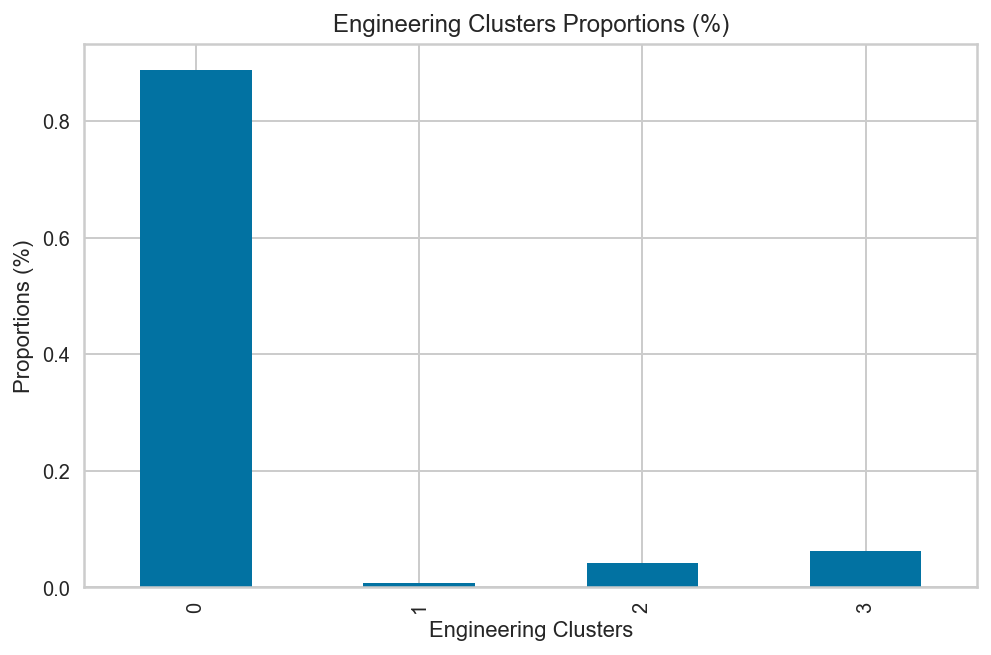

In [171]:
# Compare the proportion of data in each cluster 

# _c --> count
clusters_eng_c = pd.Series(clusters_eng).value_counts().sort_index()

# Calculate proprotions
prop_eng = clusters_eng_c / clusters_eng_c.sum()

# PLOT
plt.figure(figsize=(8, 5))
prop_eng.plot.bar(); # .sort_values(ascending=False)
plt.title('Engineering Clusters Proportions (%)')
plt.xlabel('Engineering Clusters');
plt.ylabel('Proportions (%)');

> **NOTE:**
> - The majority of the engineering articles falls into cluster (0)

**Get the most important features(words) for cluster (0)** --> highest weights

In [172]:
centroid_eng_0 = pd.Series(model_eng.cluster_centers_[0]).sort_values(ascending=False)
centroid_eng_0.head(10)

1877    0.017750
1372    0.017700
3966    0.014444
3453    0.013374
2742    0.013104
1469    0.013037
3967    0.012072
2631    0.012040
3646    0.011510
1470    0.011247
dtype: float64

In [173]:
li = [3,5, 9]
print(np.r_[(*li,)])
np.r_[tuple(li)]

[3 5 9]


array([3, 5, 9])

In [174]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
X.iloc[0, np.r_[tuple(centroid_eng_0.head(10).index)]].index.to_list()

(547, 4083)


['engineering',
 'data',
 'uber',
 'react',
 'learning',
 'deep',
 'uber engineering',
 'javascript',
 'serverless',
 'deep learning']

https://www.geeksforgeeks.org/system-design-of-uber-app-uber-system-architecture/

**Serverless architecture** (also known as serverless computing or function as a service, FaaS) is a software design pattern where applications are hosted by a third-party service, eliminating the need for server software and hardware management by the developer. Applications are broken up into individual functions that can be invoked and scaled individually.

> **NOTE:**
> - cluster (0) --> mapped into **software design**

<br>

**Get the most important features(words) for cluster (1)**

In [175]:
centroid_eng_1 = pd.Series(model_eng.cluster_centers_[1]).sort_values(ascending=False)
centroid_eng_1.head(10)

2986    0.357038
2985    0.340344
338     0.335726
2711    0.126826
2710    0.120488
760     0.105180
3282    0.099923
397     0.089027
396     0.084578
137     0.081465
dtype: float64

In [176]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
print(X.iloc[0, np.r_[tuple(centroid_eng_1.head(3).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_eng_1.iloc[3:10].index)]].index.to_list()

(547, 4083)
['microservice architecture', 'microservice', 'architecture']


['layers microservice',
 'layers',
 'building microservice',
 'practices building',
 'authentication authorization',
 'authentication',
 'agile software']

> **NOTE:**
> - cluster (1) --> mapped into **microservice1**

<br>

**Get the most important features(words) for cluster (2)**

In [177]:
centroid_eng_2 = pd.Series(model_eng.cluster_centers_[2]).sort_values(ascending=False)
centroid_eng_2.head(10)

2826    0.261779
2825    0.251621
2742    0.250226
4008    0.038074
95      0.033131
2746    0.032768
94      0.030935
1956    0.027956
4006    0.025887
2753    0.025252
dtype: float64

In [178]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
print(X.iloc[0, np.r_[tuple(centroid_eng_2.head(3).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_eng_2.iloc[3:10].index)]].index.to_list()

(547, 4083)
['machine learning', 'machine', 'learning']


['using machine',
 'adversarial examples',
 'learning machine',
 'adversarial',
 'examples',
 'using',
 'learning production']

> **NOTE:**
> - cluster (2) --> mapped into **Machine Learning**

<br>

**Get the most important features(words) for cluster (3)**

In [179]:
centroid_eng_3 = pd.Series(model_eng.cluster_centers_[3]).sort_values(ascending=False)
centroid_eng_3.head(10)

2989    0.290488
2990    0.043228
338     0.040043
3467    0.028165
2991    0.020815
335     0.020764
3576    0.019800
3942    0.019490
3041    0.018911
2091    0.018911
dtype: float64

In [180]:
# Get an index error --> because we should locate columns and not rows
print(X_eng.shape)
# X.iloc[0, np.r_[tuple(centroid_eng_3.head(10).index)]].index.to_list()

print(X.iloc[0, np.r_[tuple(centroid_eng_3.head(1).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_eng_3.iloc[1:10].index)]].index.to_list()

(547, 4083)
['microservices']


['microservices architecture',
 'architecture',
 'real',
 'microservices fail',
 'architectural',
 'running',
 'transition',
 'modules',
 'flip']

> **NOTE:**
> - I think cluster (3) and cluster (1) should be merged, because they are almost affected by the same features.
> - cluster (3) --> mapped into **microservice2**

## Save Engineering Clusters

In [181]:
# engineering_clusters = df[['body', 'title', 'category']].query(" category == 'Engineering' ")
# engineering_clusters['sub_category'] = clusters_eng
# engineering_clusters['sub_category'] = engineering_clusters.sub_category.map({0: 'software design', 1: 'microservice1', 2: 'Machine Learning', 3: 'microservice2'})
# print(engineering_clusters.shape)
# print(f'Value Counts:\n{engineering_clusters.sub_category.value_counts()}')
# engineering_clusters.head(1)

In [182]:
# engineering_clusters.to_json('Clustered_Subcategories/engineering_clusters.json')

<br>

<a id='product'></a> 
### Feature Extraction (Product & Design)
<ul>
<li><a href="#eng">Engineering</a></li>
<li><a href="#product"><b>Product & Design</b></a></li>
<li><a href="#business">Startups & Business</a></li>
</ul>

In [183]:
df_prod = X_to_filter.query(" article_category == 'Product & Design'")
X_prod = df_prod.iloc[:, 1:]
print(X_prod.shape)
X_prod.head(1)

(846, 4083)


,aarron,able,abstraction,abstractions,abstractive,abuse,academia,accelerate,accelerates,accelerator,...,writer,writing,wrong,wrong right,year,years,york,zapier,zero,zero million
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_prod_scaled = scaler.fit_transform(X_product) #Mean=0, Std=1

# X_prod_scaled = pd.DataFrame(data_prod_scaled, columns=list(X_engineering.columns))
# print(X_prod_scaled.shape)
# X_prod_scaled.head(1)

In [185]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_prod_pca = pca.fit_transform(X_prod)

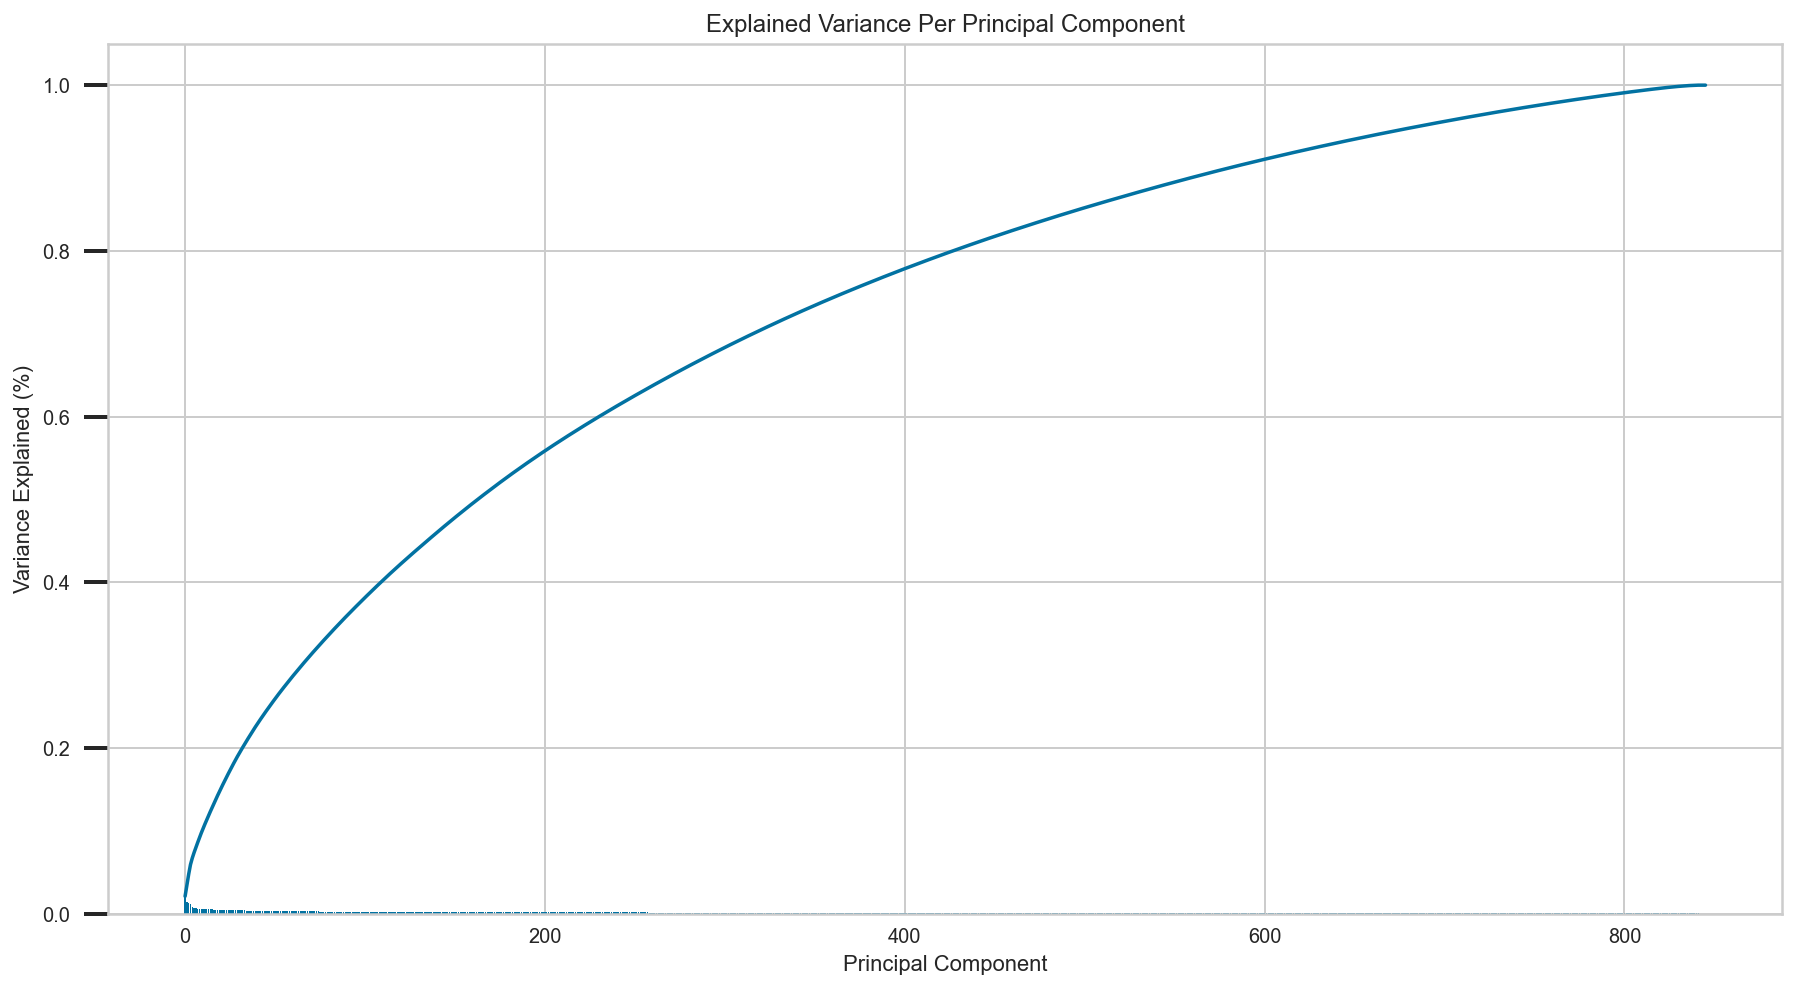

In [186]:
# To get the number of pca components to use (highest variance)
helper.scree_plot(pca)

In [187]:
# Re-apply PCA to the data while selecting for number of components to retain.

num_components=len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_

cumvals = np.cumsum(vals)
ind = next(x[0] for x in enumerate(cumvals) if x[1] > 0.8)
num_comps = ind+1
num_comps

print(f'{num_comps} PCA components --> allow us to capture {round(cumvals[num_comps-1]*100,2)}% of data variability')

428 PCA components --> allow us to capture 80.01% of data variability


In [188]:
pca = PCA(n_components=num_comps)
X_prod_pca = pca.fit_transform(X_eng)

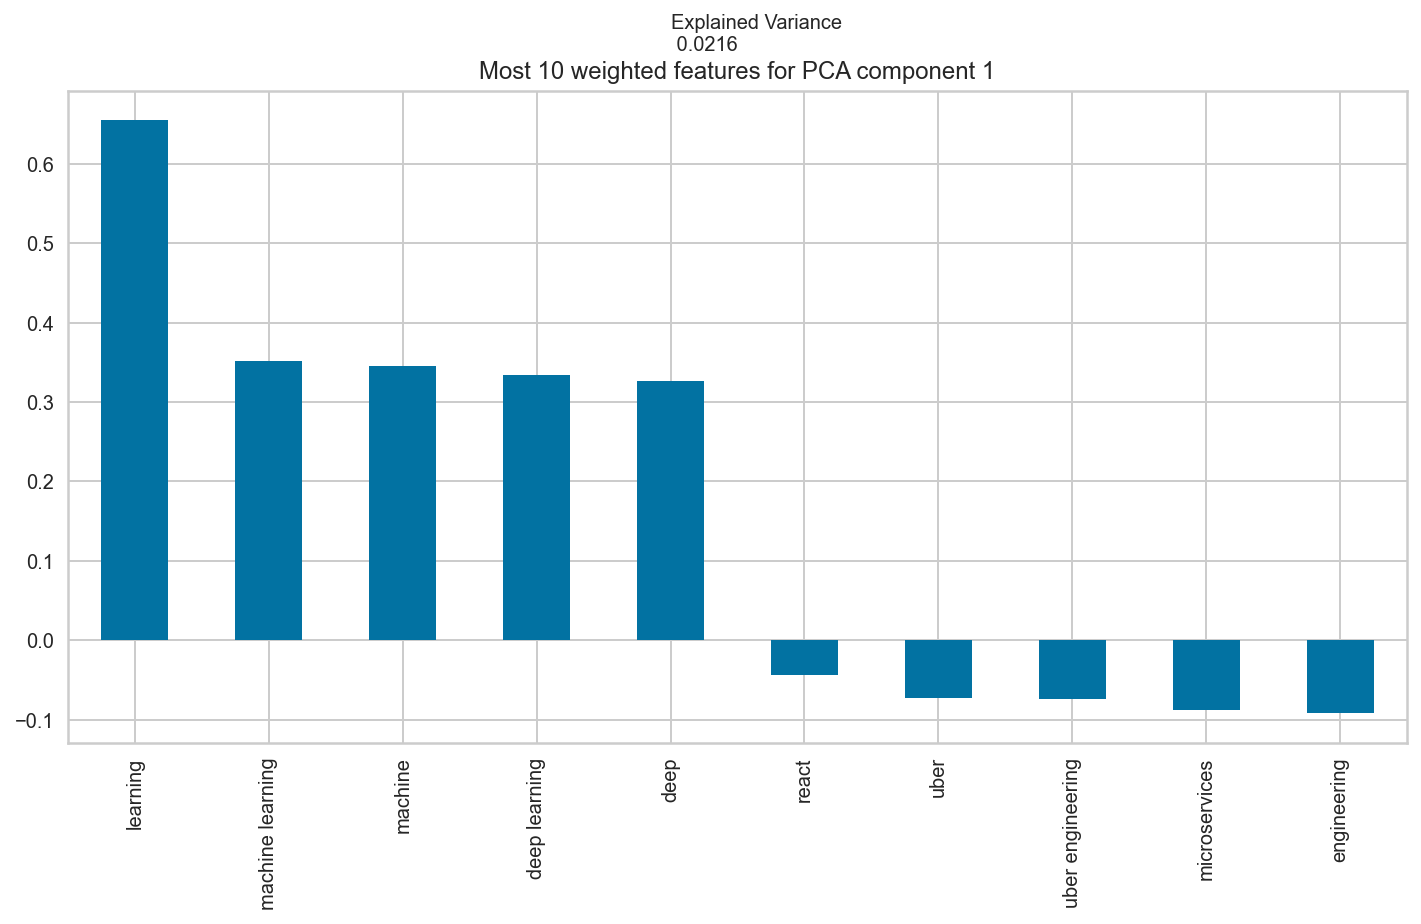

learning            0.6547
machine learning    0.3519
machine             0.3450
deep learning       0.3334
deep                0.3264
react              -0.0439
uber               -0.0726
uber engineering   -0.0735
microservices      -0.0875
engineering        -0.0921
Name: 0, dtype: float64


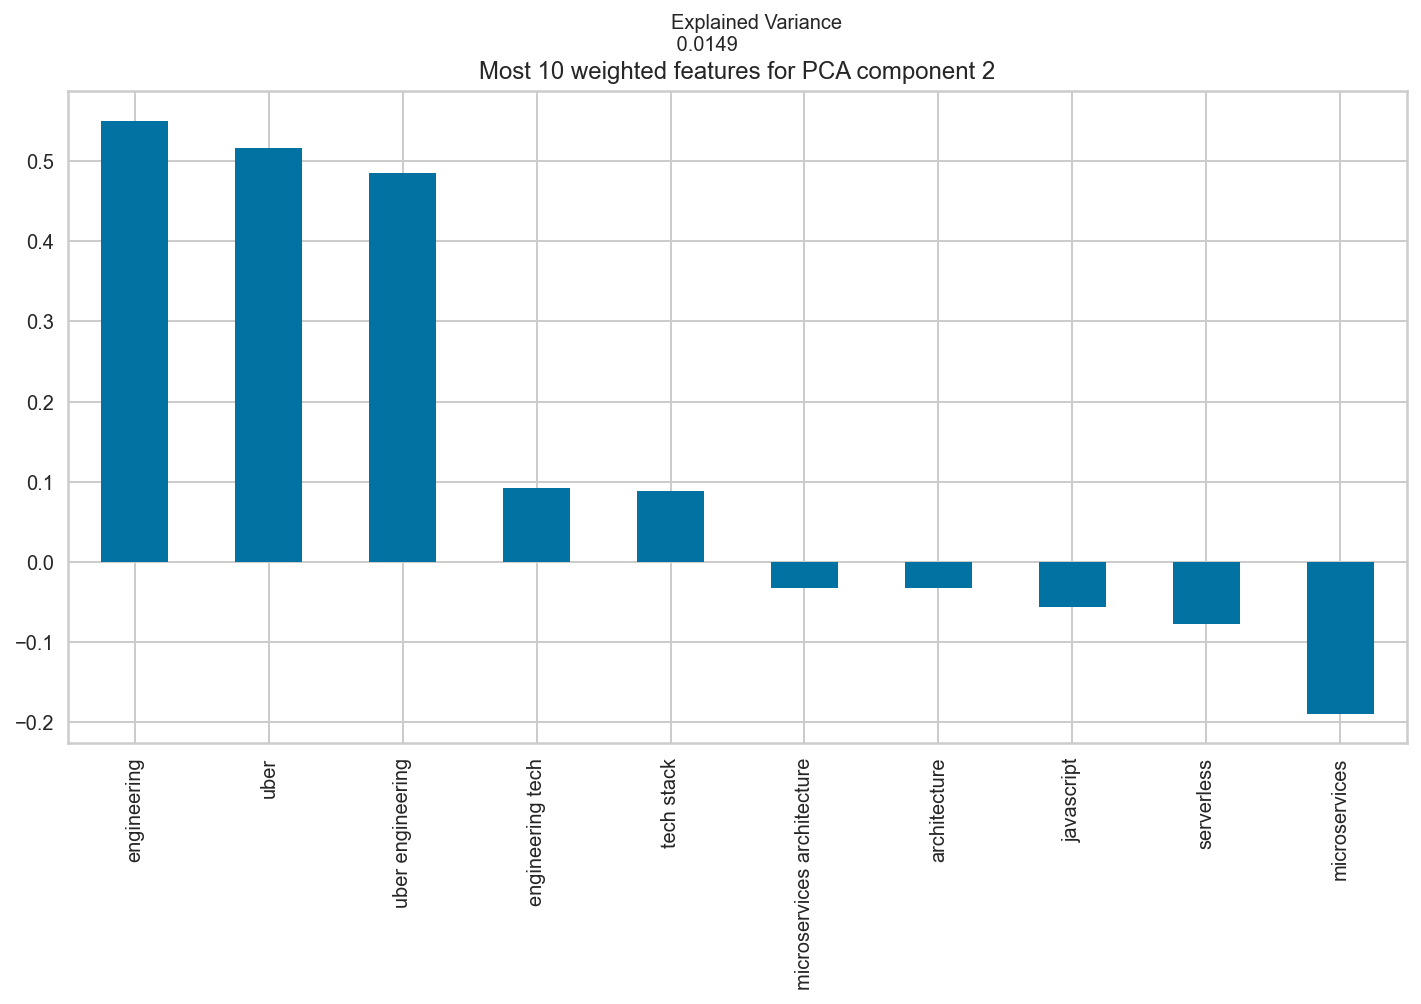

engineering                   0.5506
uber                          0.5159
uber engineering              0.4849
engineering tech              0.0916
tech stack                    0.0882
microservices architecture   -0.0321
architecture                 -0.0325
javascript                   -0.0564
serverless                   -0.0774
microservices                -0.1894
Name: 1, dtype: float64


In [189]:
# Interpret Principal Components

res = helper.pca_results(X_prod, pca, 1, 5)
print(res)

res = helper.pca_results(X_prod, pca, 2, 5)
print(res)

<br>

## Clustering (Product & Design)

In [190]:
# # Create a toy dataset to reduce computation time
# # Reduce the size to 25%
# X_pca_sample = X_pca[np.random.choice(X_pca.shape[0], int(df.shape[0]*0.25), replace=False)]

In [191]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
t0 = time()

sse = [] # Sum of Squared Errors
silhouette = []
calinski = []
k_range = np.arange(2, 21)

for k in k_range:
    kmeans = KMeans(k, random_state=42) # , max_iter=30
    model = kmeans.fit(X_prod)
    preds = model.predict(X_prod)
    # Scoring
    sil_score = silhouette_score(X_prod, preds) #, metric='cosine'
    calinski_score = calinski_harabasz_score(X_prod, preds)
    score = np.abs(model.score(X_prod))
    sse.append(score)
    silhouette.append(sil_score)
    calinski.append(calinski_score)
    
#     # Print Results
#     print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))
#     print("For n_clusters = {}, silhouette score is {})".format(k, round(sil_score, 2)))
#     print("For n_clusters = {}, calinski_harabasz score is {})".format(k, round(calinski_score, 2)))
#     print('-'*50)
    
   
print((time()-t0)/60)

0.3111797054608663


<br>

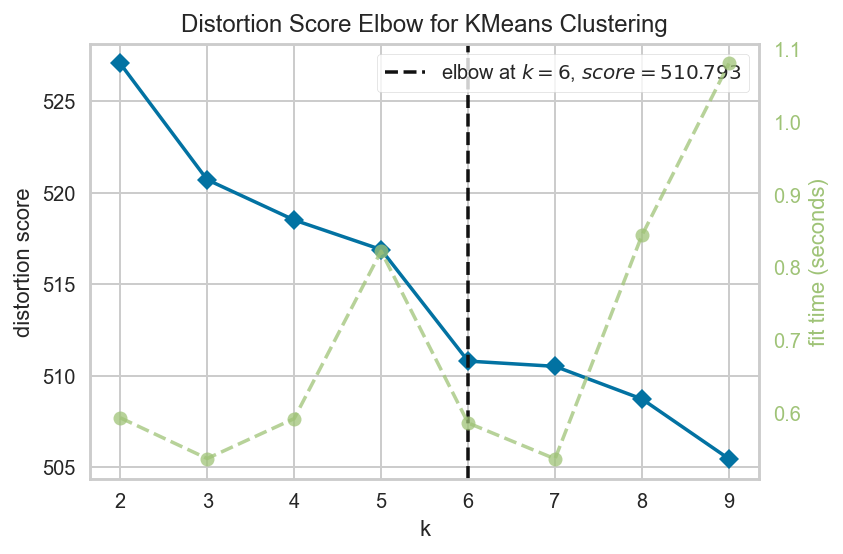

In [192]:
# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
visualizer.fit(X_prod);        # Fit the data to the visualizer
visualizer.show();             # Finalize and render the figure

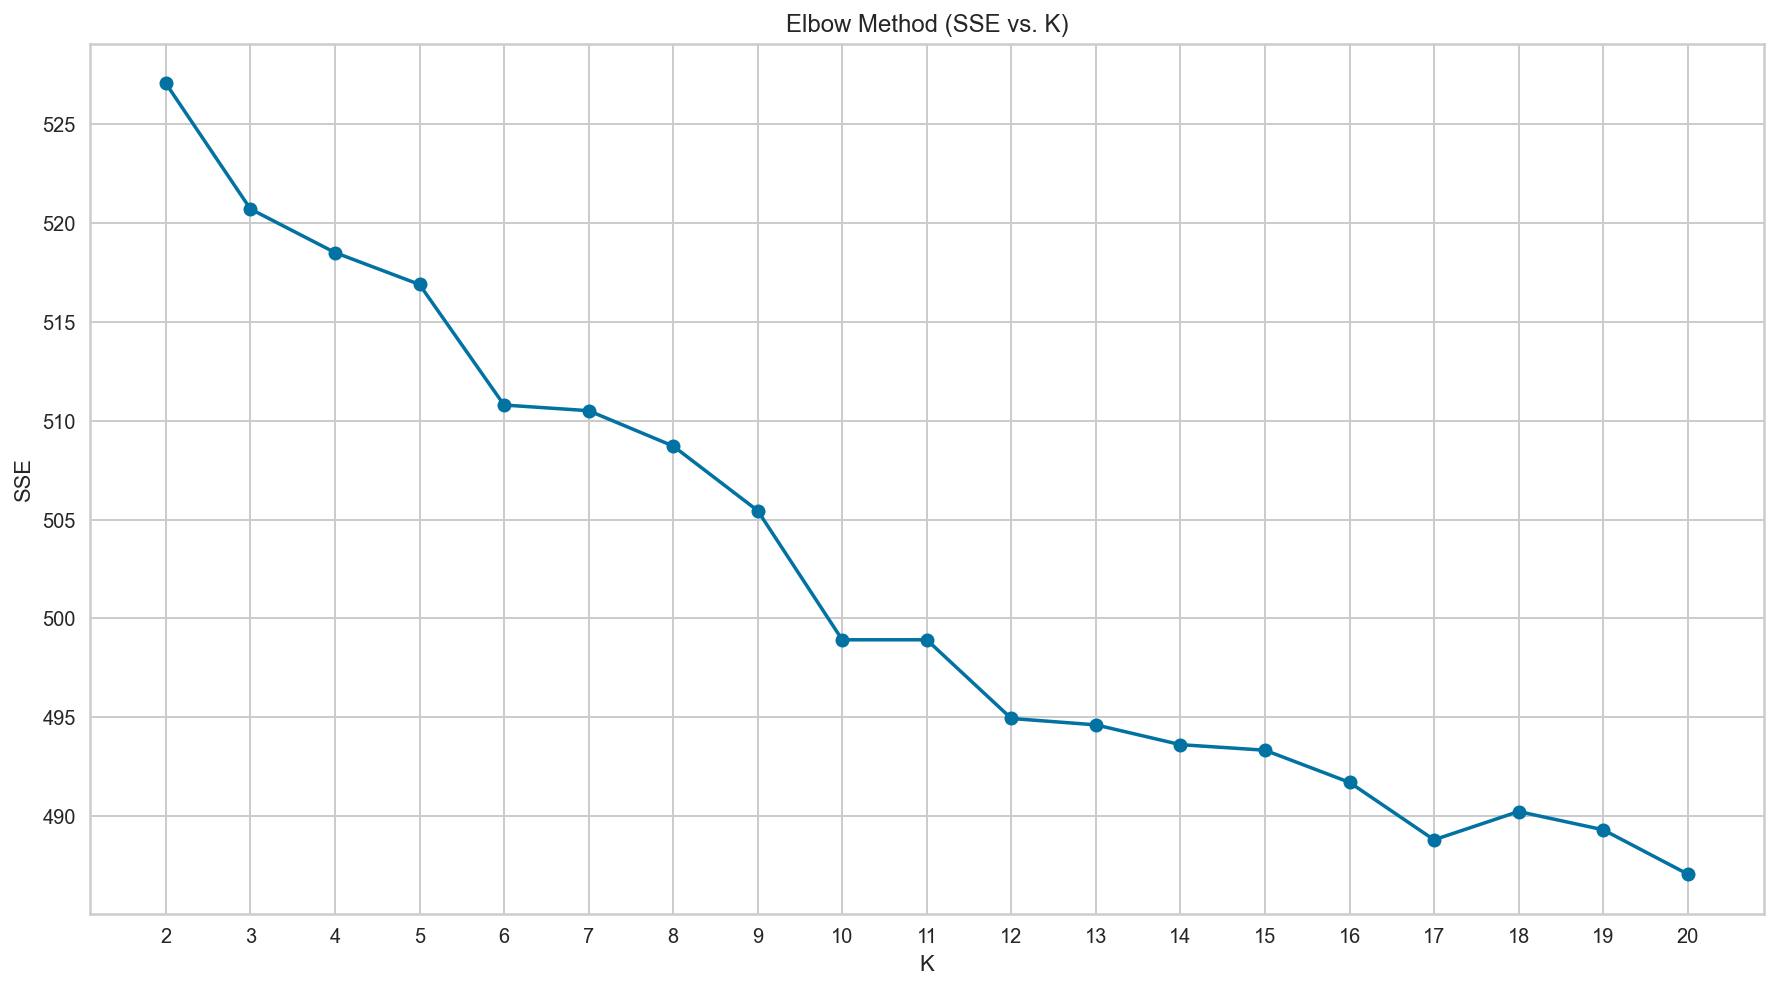

In [193]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

## Clustering Validation (Product & Design)

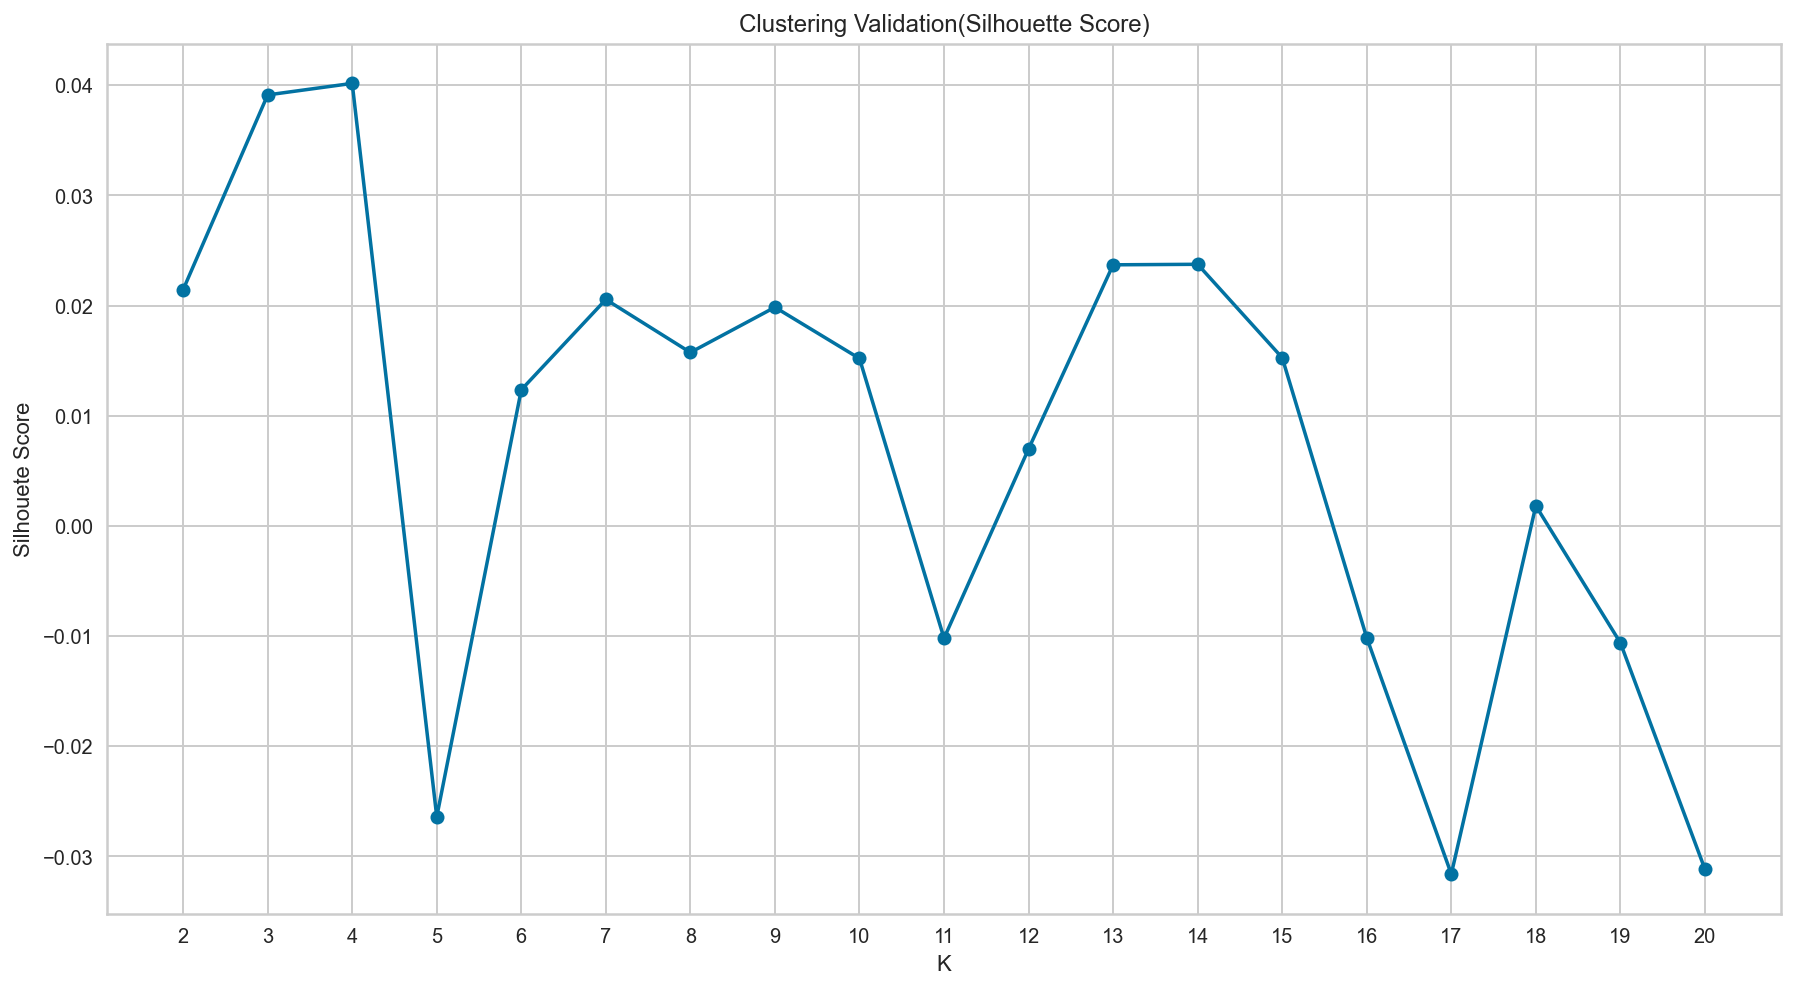

In [194]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('Silhouete Score')
plt.title('Clustering Validation(Silhouette Score)')
plt.plot(k_range, silhouette, linestyle='-', marker='o');

> **NOTE:**
> - Silhouette Score suggests k=4.

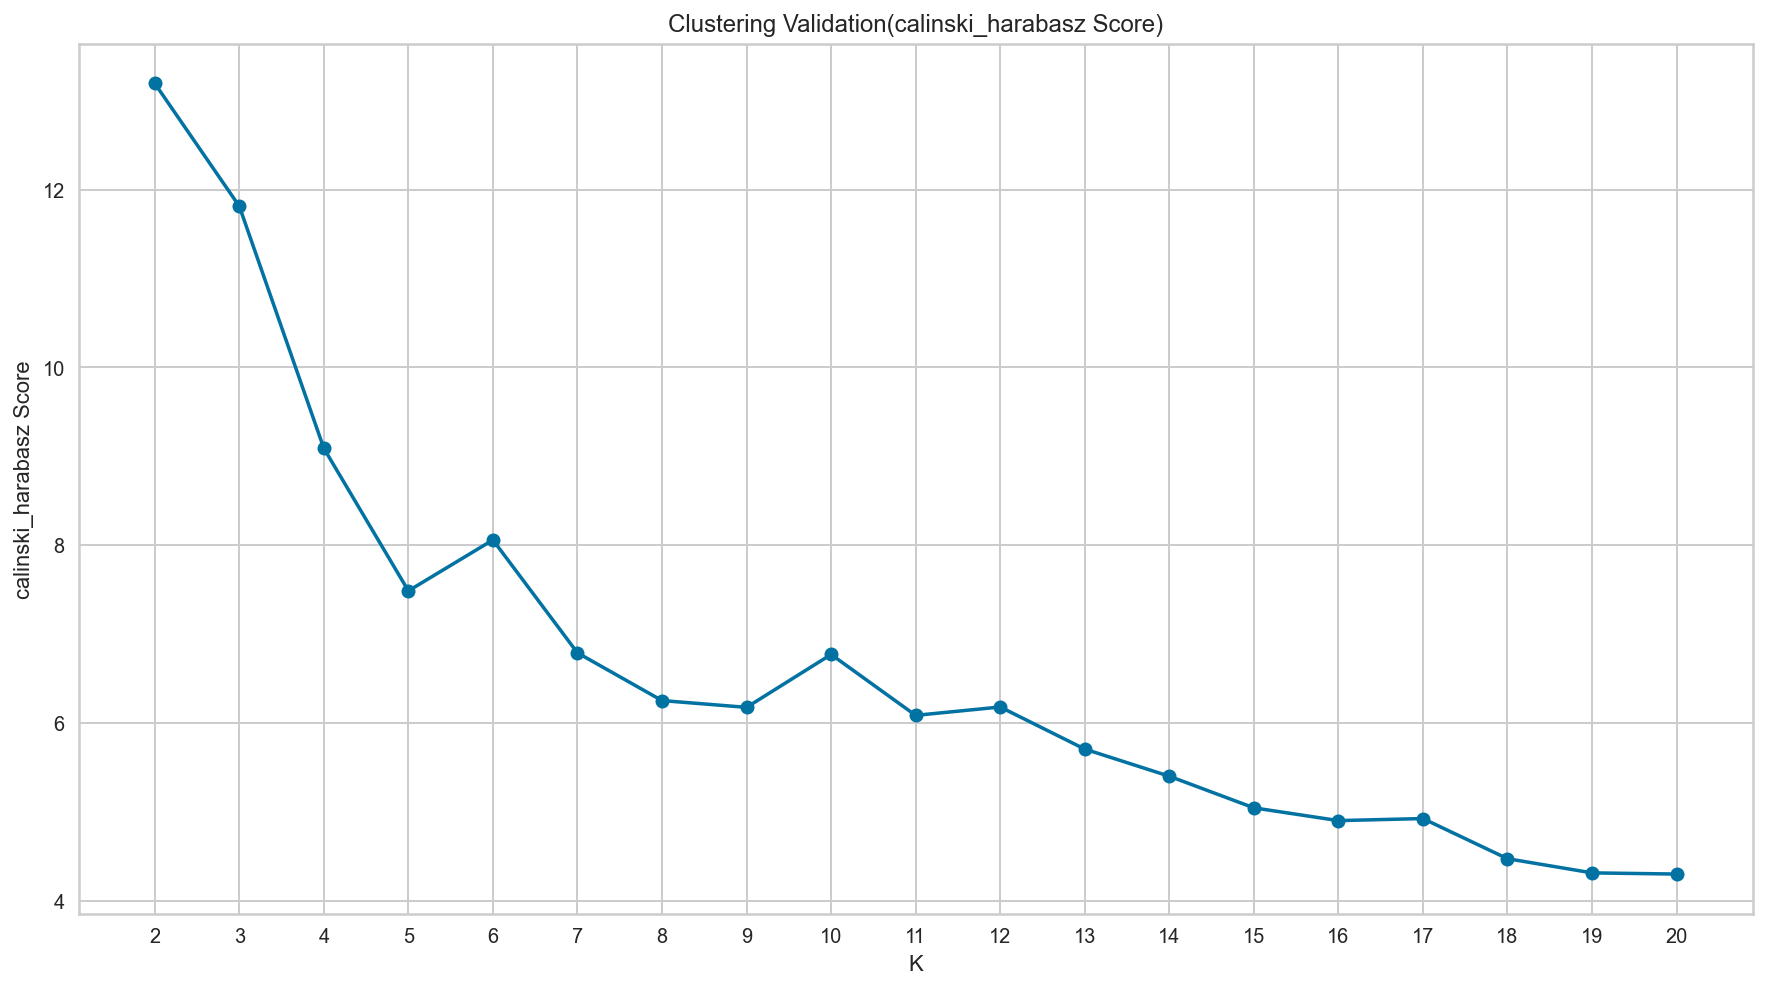

In [195]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('calinski_harabasz Score')
plt.title('Clustering Validation(calinski_harabasz Score)')
plt.plot(k_range, calinski, linestyle='-', marker='o');

In [196]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_4 = KMeans(n_clusters=4, random_state=42)
model_prod = kmeans_4.fit(X_prod)
clusters_prod = model_prod.predict(X_prod)

print(time()-t0)

0.8988969326019287


In [197]:
clusters_prod 

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 3, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

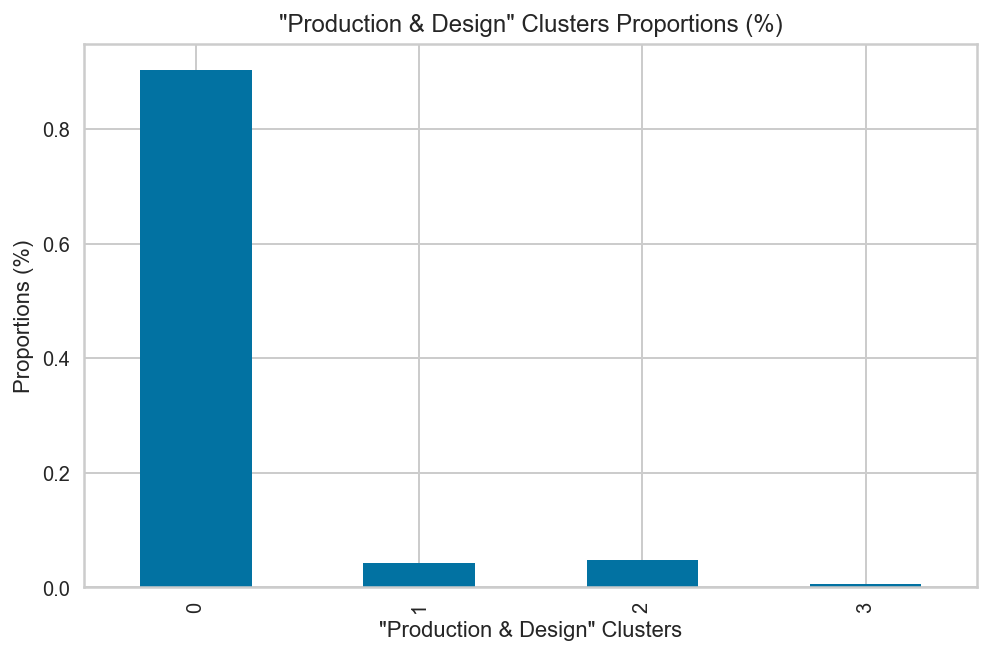

In [198]:
# Compare the proportion of data in each cluster 

# _c --> count
clusters_prod_c = pd.Series(clusters_prod).value_counts().sort_index()

# Calculate proprotions
prop_prod = clusters_prod_c / clusters_prod_c.sum()

# PLOT
plt.figure(figsize=(8, 5))
prop_prod.plot.bar(); # .sort_values(ascending=False)
plt.title('"Production & Design" Clusters Proportions (%)')
plt.xlabel('"Production & Design" Clusters');
plt.ylabel('Proportions (%)');

> **NOTE:**
> - The majority of the Product & Design articles falls into cluster (0).

**Get the most important features(words) for cluster (0)**

In [199]:
centroid_prod_0 = pd.Series(model_prod.cluster_centers_[0]).sort_values(ascending=False)
centroid_prod_0.head(10)

3331    0.043770
1518    0.040891
2885    0.011026
3995    0.010906
3351    0.010822
1603    0.010605
3378    0.009617
4003    0.008936
1325    0.008547
1594    0.008043
dtype: float64

In [200]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
X.iloc[0, np.r_[tuple(centroid_prod_0.head(10).index)]].index.to_list()

(846, 4083)


['product',
 'design',
 'managers',
 'user',
 'product managers',
 'designing',
 'products',
 'users',
 'customer',
 'designers']

> **NOTE:**
> - cluster (0) --> mapped into **product design**

<br>

**Get the most important features(words) for cluster (1)**

In [201]:
centroid_prod_1 = pd.Series(model_prod.cluster_centers_[1]).sort_values(ascending=False)
centroid_prod_1.head(10)

3350    0.296818
2876    0.287290
3331    0.215528
3163    0.026020
3008    0.019706
2877    0.019582
3880    0.018901
3562    0.018583
2338    0.017506
1646    0.017037
dtype: float64

In [202]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
print(X.iloc[0, np.r_[tuple(centroid_prod_1.head(3).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_prod_1.iloc[3:10].index)]].index.to_list()

(846, 4083)
['product manager', 'manager', 'product']


['owner',
 'mindset',
 'manager guide',
 'technical product',
 'role',
 'guide',
 'developing product']

> **NOTE:**
> - cluster (1) --> mapped into **product manager guide**

<br>

**Get the most important features(words) for cluster (2)**

In [203]:
centroid_prod_2 = pd.Series(model_prod.cluster_centers_[2]).sort_values(ascending=False)
centroid_prod_2.head(10)

3349    0.280297
2865    0.276585
3331    0.170610
859     0.024990
2856    0.023662
2869    0.020877
1986    0.019493
2867    0.018303
531     0.017335
2583    0.016879
dtype: float64

In [204]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
print(X.iloc[0, np.r_[tuple(centroid_prod_2.head(3).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_prod_2.iloc[3:10].index)]].index.to_list()

(846, 4083)
['product management', 'management', 'product']


['career',
 'making',
 'management explained',
 'explained',
 'management career',
 'best practices',
 'interview']

> **NOTE:**
> - cluster (2) --> mapped into **management best practices**

<br>

**Get the most important features(words) for cluster (3)**

In [205]:
centroid_prod_3 = pd.Series(model_prod.cluster_centers_[3]).sort_values(ascending=False)
centroid_prod_3.head(10)

1376    0.370871
1741    0.336212
1372    0.289532
2119    0.110572
1742    0.096396
2118    0.093497
1340    0.085508
1744    0.083895
1748    0.078874
1381    0.077570
dtype: float64

In [206]:
# Get an index error --> because we should locate columns and not rows
print(X_prod.shape)
X.iloc[0, np.r_[tuple(centroid_prod_3.head(10).index)]].index.to_list()

(846, 4083)


['data driven',
 'driven',
 'data',
 'foundation data',
 'driven customer',
 'foundation',
 'customer retention',
 'driven design',
 'driven usability',
 'data informed']

> **NOTE:**
> - cluster (2) --> mapped into **data-driven decisions**

<br>

<a id='business'></a> 
### Feature Extraction (Startups & Business)
<ul>
<li><a href="#eng">Engineering</a></li>
<li><a href="#product">Product & Design</a></li>
<li><a href="#business"><b>Startups & Business</b></a></li>
</ul>

In [207]:
df_business = X_to_filter.query(" article_category == 'Startups & Business'")
X_business = df_business.iloc[:, 1:]
print(X_business.shape)
X_business.head(1)

(1061, 4083)


,aarron,able,abstraction,abstractions,abstractive,abuse,academia,accelerate,accelerates,accelerator,...,writer,writing,wrong,wrong right,year,years,york,zapier,zero,zero million
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_business_scaled = scaler.fit_transform(X_business) #Mean=0, Std=1

# X_business_scaled = pd.DataFrame(data_business_scaled, columns=list(X_engineering.columns))
# print(X_business_scaled.shape)
# X_business_scaled.head(1)

In [209]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_business_pca = pca.fit_transform(X_business)

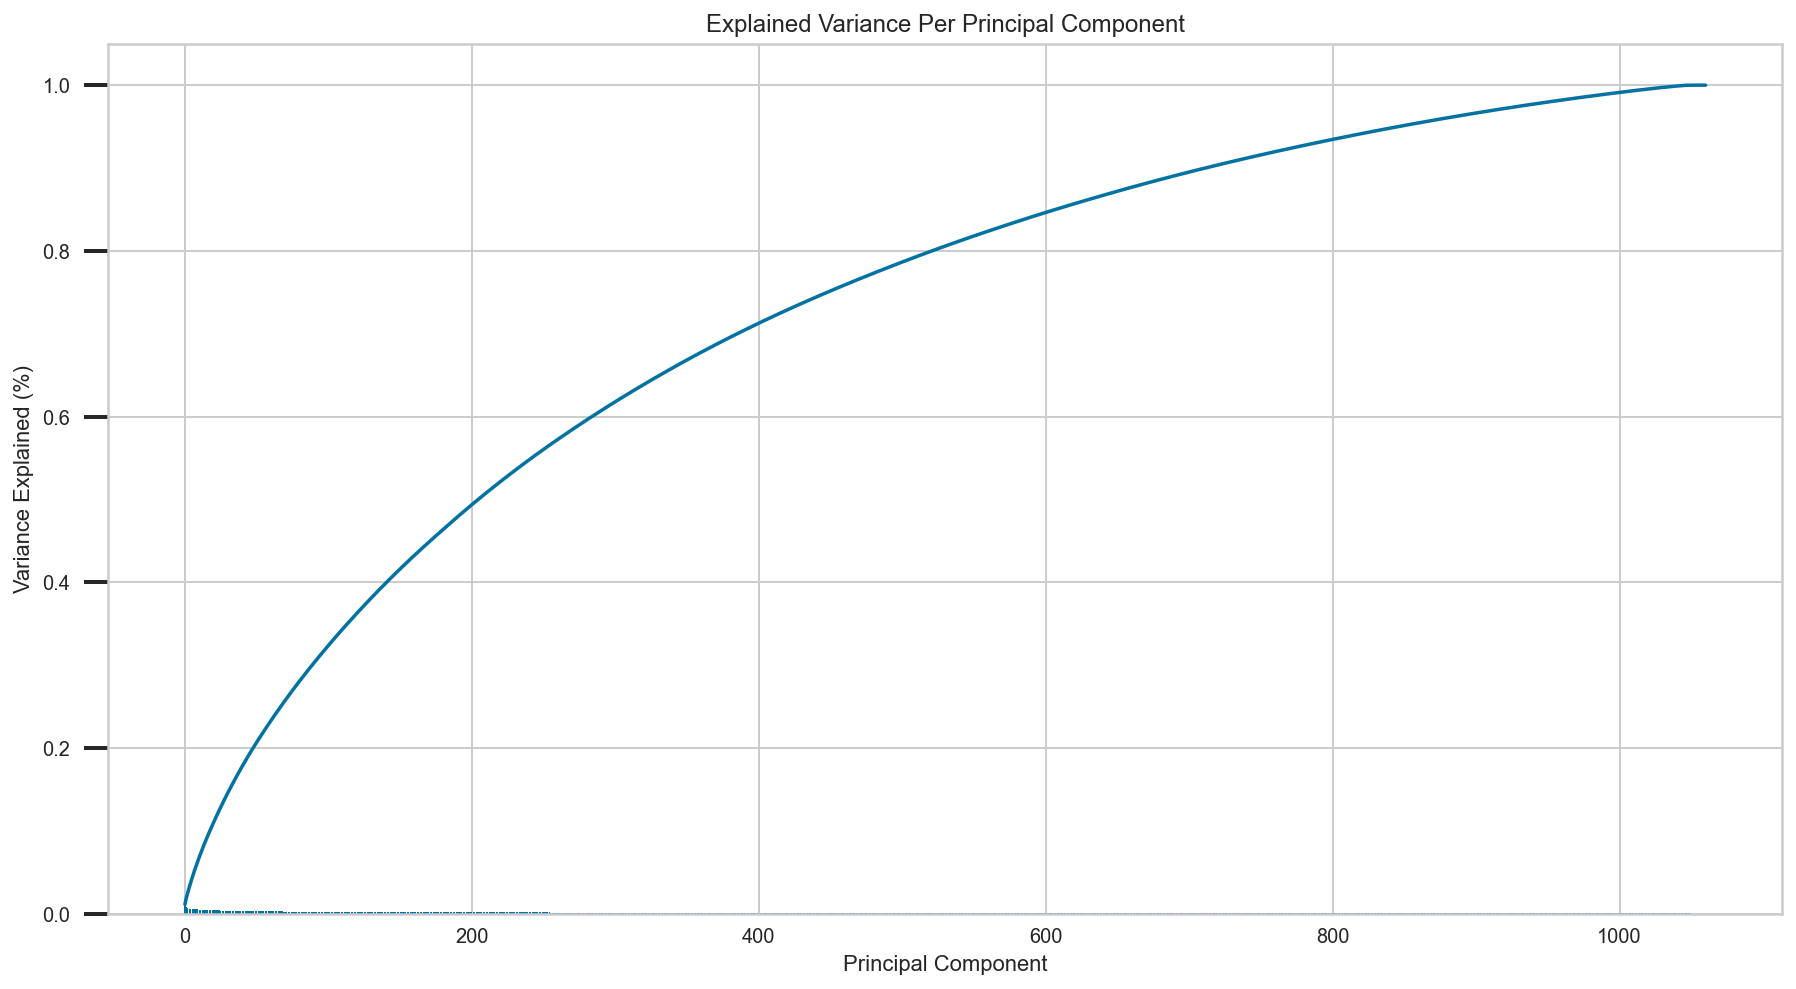

In [210]:
# To get the number of pca components to use (highest variance)
helper.scree_plot(pca)

In [211]:
# Re-apply PCA to the data while selecting for number of components to retain.

num_components=len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_

cumvals = np.cumsum(vals)
ind = next(x[0] for x in enumerate(cumvals) if x[1] > 0.8)
num_comps = ind+1
num_comps

print(f'{num_comps} PCA components --> allow us to capture {round(cumvals[num_comps-1]*100,2)}% of data variability')

522 PCA components --> allow us to capture 80.01% of data variability


In [212]:
pca = PCA(n_components=num_comps)
X_business_pca = pca.fit_transform(X_business)

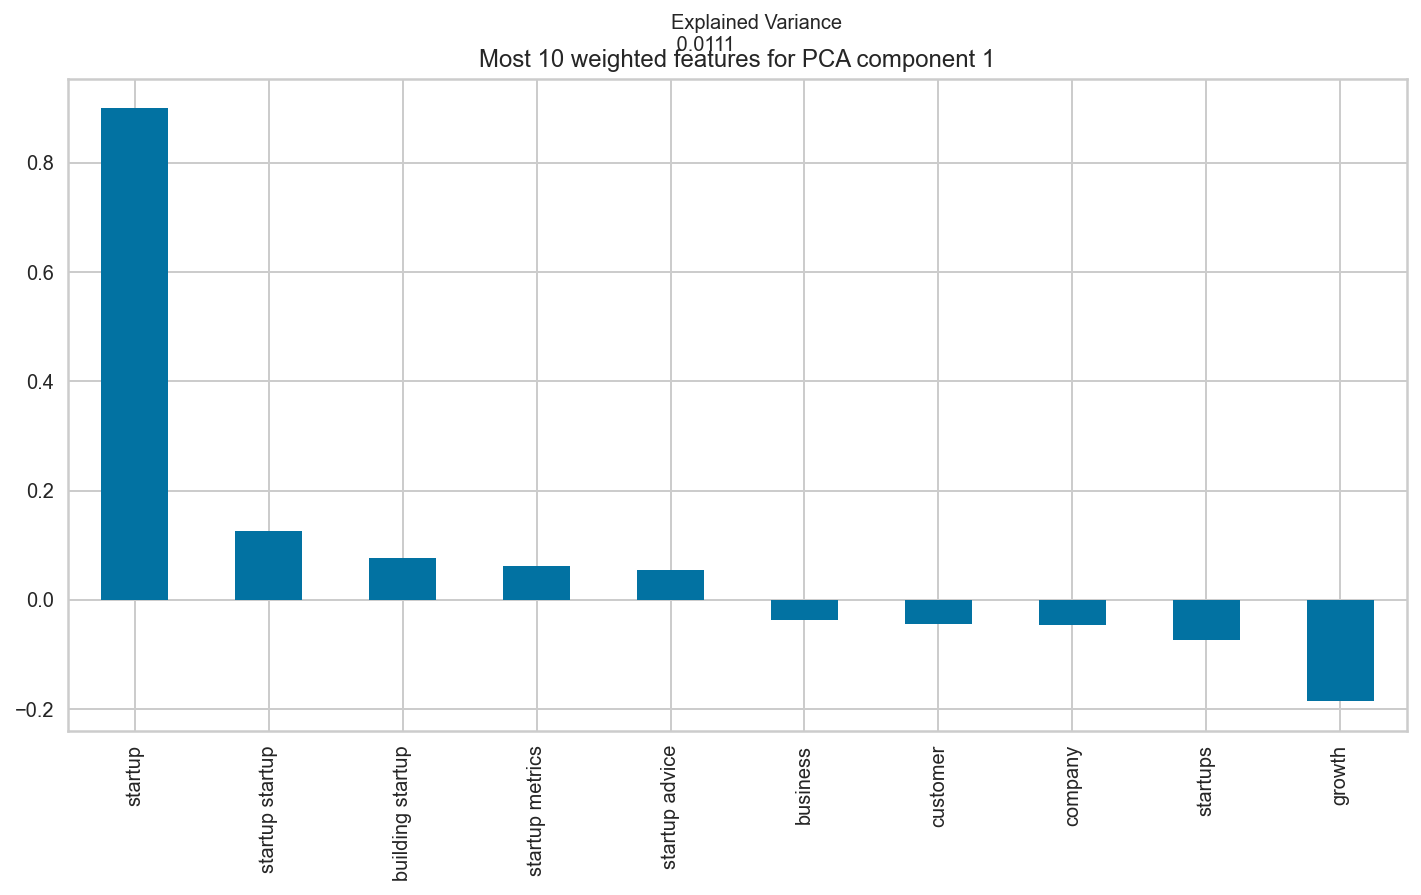

startup             0.8999
startup startup     0.1265
building startup    0.0774
startup metrics     0.0627
startup advice      0.0552
business           -0.0370
customer           -0.0434
company            -0.0465
startups           -0.0734
growth             -0.1858
Name: 0, dtype: float64


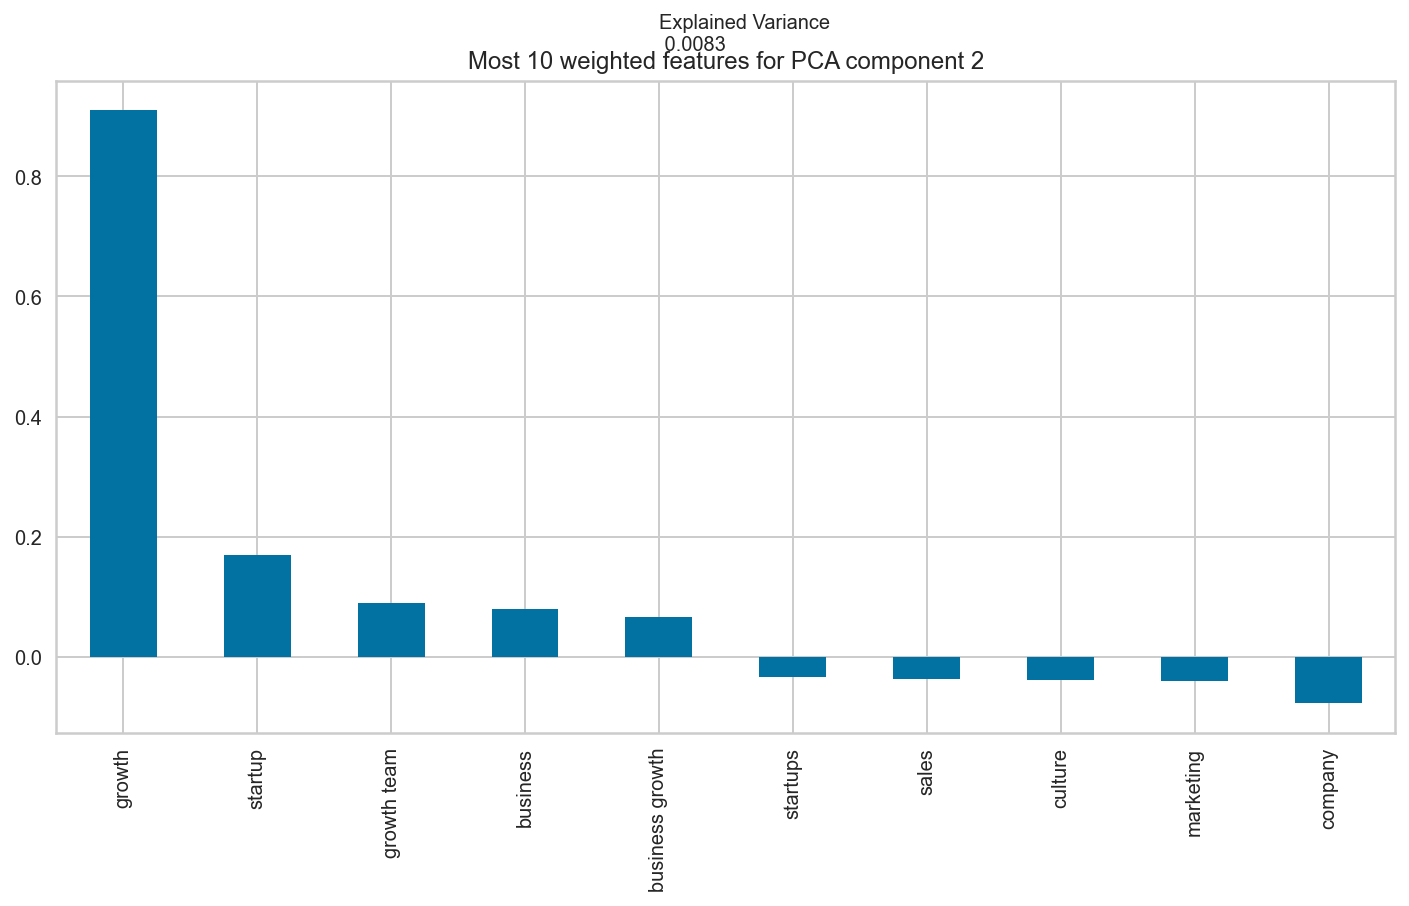

growth             0.9098
startup            0.1696
growth team        0.0898
business           0.0796
business growth    0.0664
startups          -0.0334
sales             -0.0367
culture           -0.0378
marketing         -0.0398
company           -0.0774
Name: 1, dtype: float64


In [213]:
# Interpret Principal Components

res = helper.pca_results(X_business, pca, 1, 5)
print(res)

res = helper.pca_results(X_business, pca, 2, 5)
print(res)

<br>

## Clustering (Startup & Business)

In [214]:
# # Create a toy dataset to reduce computation time
# # Reduce the size to 25%
# X_pca_sample = X_pca[np.random.choice(X_pca.shape[0], int(df.shape[0]*0.25), replace=False)]

In [215]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
t0 = time()

sse = [] # Sum of Squared Errors
silhouette = []
calinski = []
k_range = np.arange(2, 21)

for k in k_range:
    kmeans = KMeans(k, random_state=42) # , max_iter=30
    model = kmeans.fit(X_business)
    preds = model.predict(X_business)
    # Scoring
    sil_score = silhouette_score(X_business, preds) #, metric='cosine'
    calinski_score = calinski_harabasz_score(X_business, preds)
    score = np.abs(model.score(X_business))
    sse.append(score)
    silhouette.append(sil_score)
    calinski.append(calinski_score)
    
#     # Print Results
#     print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))
#     print("For n_clusters = {}, silhouette score is {})".format(k, round(sil_score, 2)))
#     print("For n_clusters = {}, calinski_harabasz score is {})".format(k, round(calinski_score, 2)))
#     print('-'*50)
    
   
print((time()-t0)/60)

0.5161958853403728


<br>

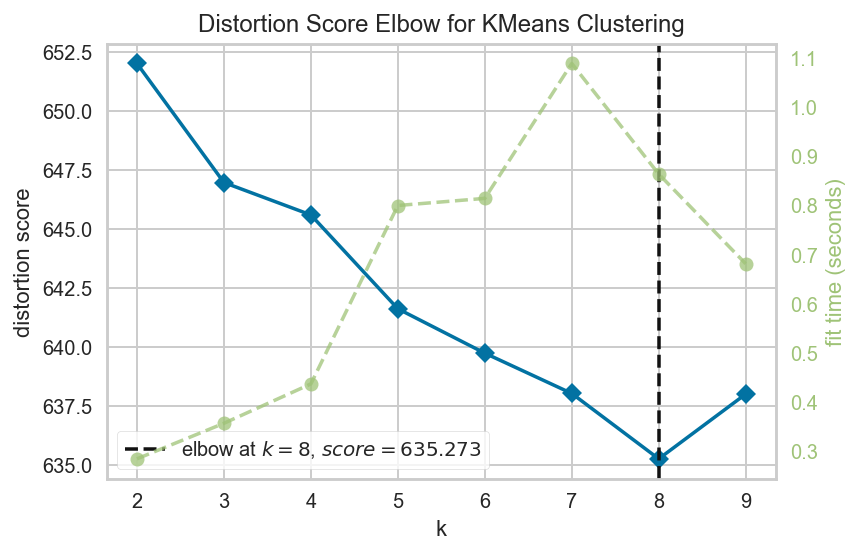

In [216]:
# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
visualizer.fit(X_business);        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

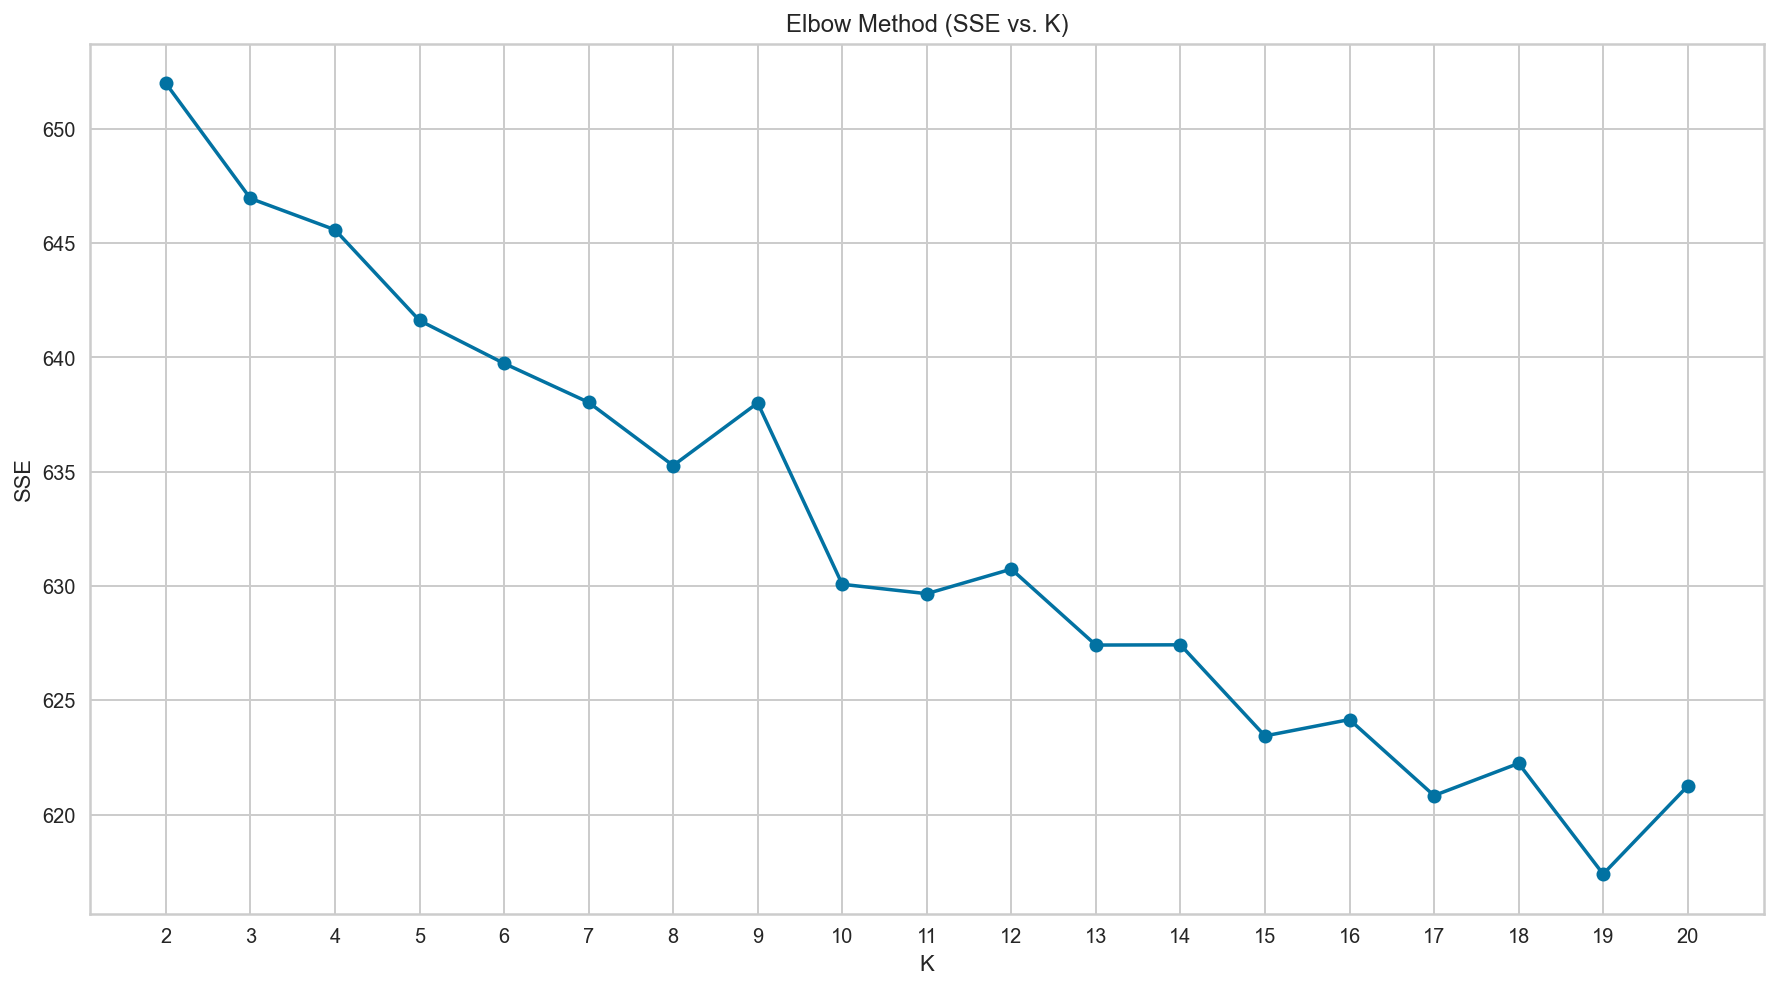

In [217]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

## Clustering Validation (Startups & Business)

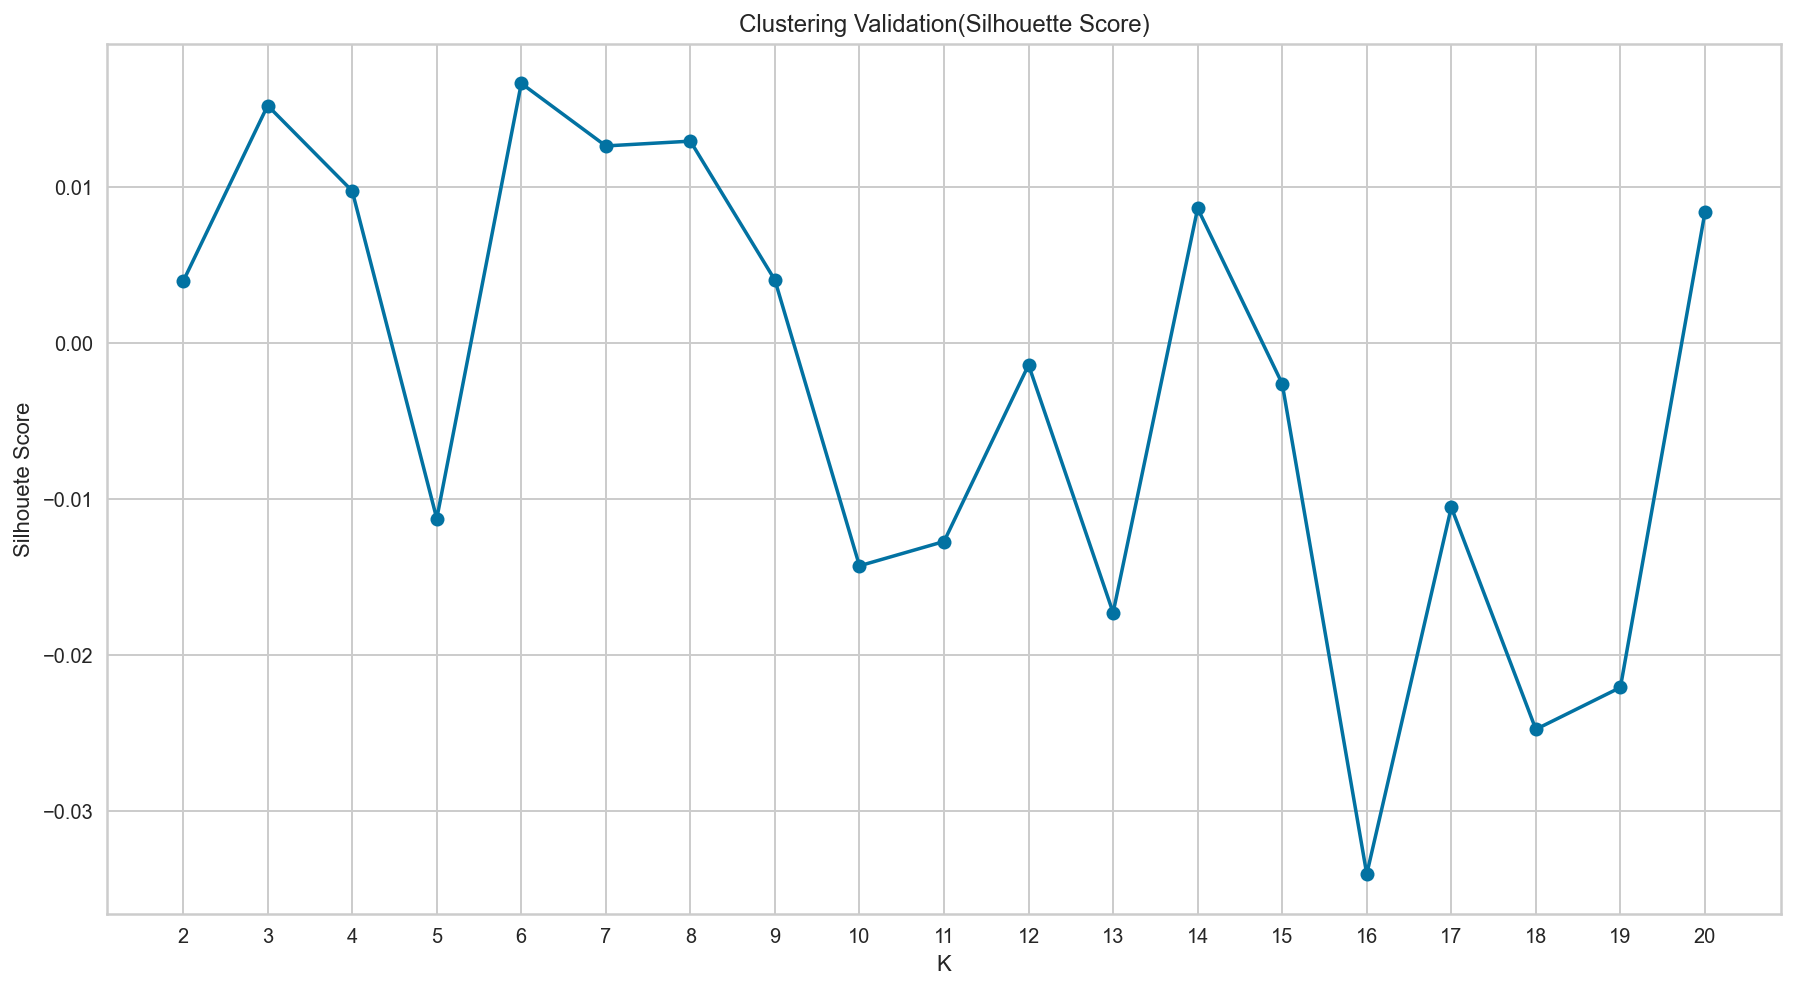

In [218]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('Silhouete Score')
plt.title('Clustering Validation(Silhouette Score)')
plt.plot(k_range, silhouette, linestyle='-', marker='o');

> **NOTE:**
> - Silhouette Score suggests k=3 or k=6.

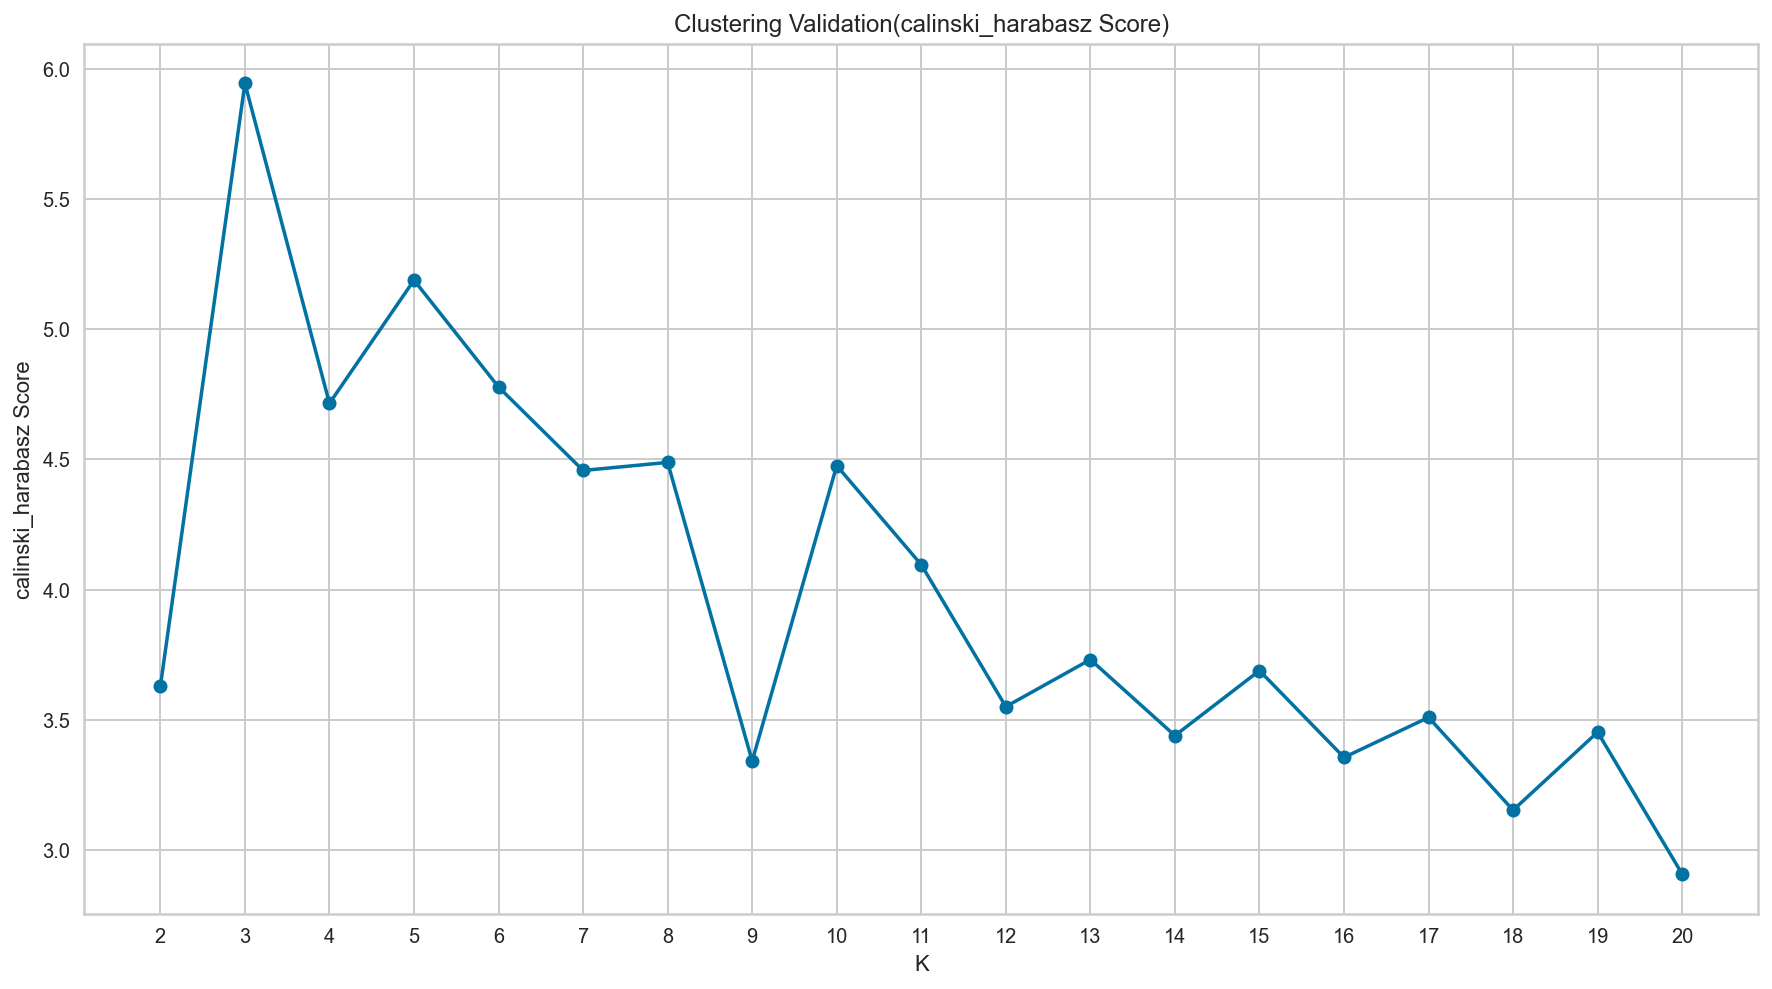

In [219]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('calinski_harabasz Score')
plt.title('Clustering Validation(calinski_harabasz Score)')
plt.plot(k_range, calinski, linestyle='-', marker='o');

> **NOTE:**
> - calinski_harabasz Score suggests k=3.

In [220]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_3 = KMeans(n_clusters=3, random_state=42)
model_st = kmeans_3.fit(X_business)
clusters_business = model_st.predict(X_business)

print(time()-t0)

0.9673831462860107


In [221]:
# clusters_business 

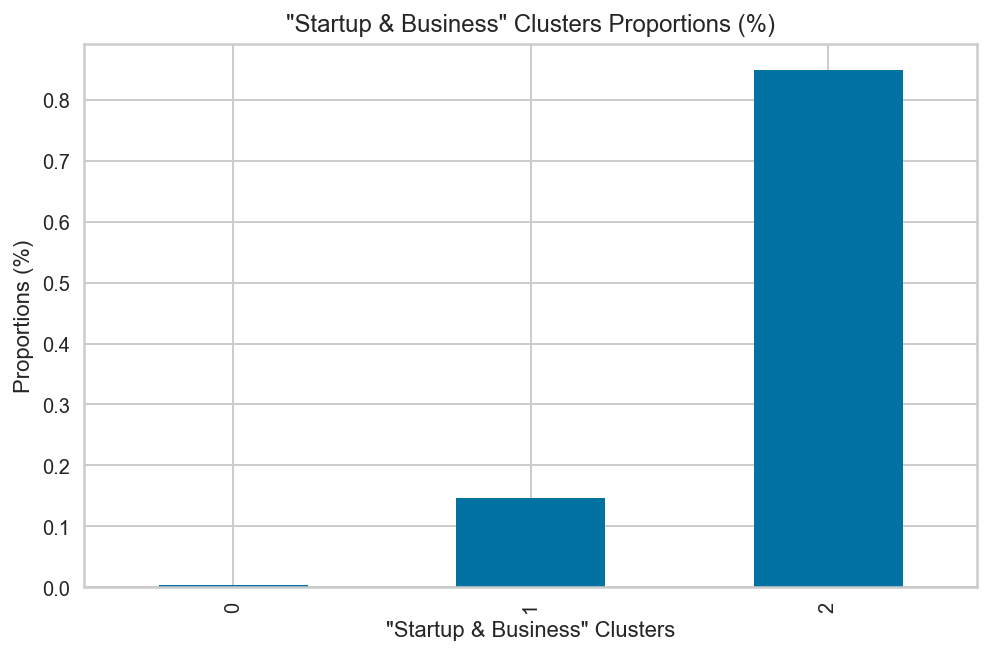

In [222]:
# Compare the proportion of data in each cluster 

# _c --> count, st --> startup
clusters_st_c = pd.Series(clusters_business).value_counts().sort_index()

# Calculate proprotions
prop_st = clusters_st_c / clusters_st_c.sum()

# PLOT
plt.figure(figsize=(8, 5))
prop_st.plot.bar(); # .sort_values(ascending=False)
plt.title('"Startup & Business" Clusters Proportions (%)')
plt.xlabel('"Startup & Business" Clusters');
plt.ylabel('Proportions (%)');

> **NOTE:**
> - The majority of the Startup & Business articles falls into one cluster (2).

**Get the most important features(words) for cluster (0)**

In [223]:
centroid_st_0 = pd.Series(model_st.cluster_centers_[0]).sort_values(ascending=False)
centroid_st_0.head(10)

3019    0.235367
1437    0.186668
3754    0.149725
2662    0.119567
3021    0.113592
1438    0.111732
2858    0.106147
2129    0.102826
3584    0.101104
1061    0.097687
dtype: float64

In [224]:
# Got an index error --> because we should locate columns and not rows
print(X_business.shape)
X.iloc[0, np.r_[tuple(centroid_st_0.head(10).index)]].index.to_list()

(1061, 4083)


['mistakes',
 'dear',
 'startup',
 'kill saas',
 'mistakes kill',
 'dear startup',
 'making mistakes',
 'founder mistakes',
 'saas startup',
 'common startup']

> **NOTE:**
> - cluster (0) --> mapped into **Startups Mistakes**

<br>

**Get the most important features(words) for cluster (1)**

In [225]:
centroid_st_1 = pd.Series(model_st.cluster_centers_[1]).sort_values(ascending=False)
centroid_st_1.head(10)

3754    0.200239
3773    0.011949
3227    0.011755
772     0.010737
709     0.010394
3044    0.010062
3441    0.010040
3766    0.009748
2980    0.009705
3755    0.009676
dtype: float64

In [226]:
# Got an index error --> because we should locate columns and not rows
print(X_business.shape)
X.iloc[0, np.r_[tuple(centroid_st_1.head(10).index)]].index.to_list()

(1061, 4083)


['startup',
 'startup startup',
 'pitch',
 'building startup',
 'build',
 'money',
 'raising',
 'startup metrics',
 'metrics',
 'startup advice']

> **NOTE:**
> - cluster (1) --> mapped into **Start Startup**

<br>

**Get the most important features(words) for cluster (2)**

In [227]:
centroid_st_2 = pd.Series(model_st.cluster_centers_[2]).sort_values(ascending=False)
centroid_st_2.head(10)

2317    0.016188
3780    0.013666
1085    0.011668
795     0.010154
3331    0.009614
3587    0.009331
2762    0.008588
2907    0.008432
1325    0.007830
3866    0.007194
dtype: float64

In [228]:
# Got an index error --> because we should locate columns and not rows
print(X_business.shape)
X.iloc[0, np.r_[tuple(centroid_st_2.head(10).index)]].index.to_list()

(1061, 4083)


['growth',
 'startups',
 'company',
 'business',
 'product',
 'sales',
 'lessons',
 'marketing',
 'customer',
 'team']

> **NOTE:**
> - cluster (2) --> mapped into **Startup Growth**

<br>

<br>

**Recommendation based on book title**

In [229]:
'startup & business'.title()

'Startup & Business'

In [230]:
data = df.loc[df['category'] == 'Engineering']  
data.reset_index(level = 0, inplace = True)
data.head(1)

,index,body,title,category,title_clean,body_clean
0,1,JAXenter: Have microservices helped you achiev...,"""The size of a microservice is the size of the...",Engineering,size microservice size team building,jaxenter microservices helped achieve goals av...


In [231]:
indices = pd.Series(data.index, index = data['title'])
indices.head()

title
"The size of a microservice is the size of the team that is building it"    0
"Transition to microservices while running under full steam is not easy"    1
10 JavaScript concepts every Node.js programmer must master | InfoWorld     2
10 Languages That Compile to JavaScript                                     3
10 Lessons in Microservices: a Utopian Mystery                              4
dtype: int64

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [232]:
# # Function for recommending books based on Book title. It takes book title and genre as an input.

# def recommend(title, category):
    
#     # Matching the genre with the dataset and reset the index
#     data = df.loc[df['category'] == category]  
#     data.reset_index(level = 0, inplace = True) 
  
#     # Convert the index into series
#     indices = pd.Series(data.index, index = data['title'])
    
#     #Converting the book title into vectors and used bigram
#     # (2, 2) means only bigrams, (1, 2) means unigrams and bigrams
#     tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')
#     tfidf_matrix = tf.fit_transform(data['title'])
    
#     # Calculating the similarity measures based on Cosine Similarity
#     sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
#     # Get the index corresponding to original_title
       
#     idx = indices[title]# Get the pairwsie similarity scores 
#     sig = list(enumerate(sg[idx]))# Sort the books
#     sig = sorted(sig, key=lambda x: x[1], reverse=True)# Scores of the 5 most similar books 
#     sig = sig[1:6]# Book indicies
#     movie_indices = [i[0] for i in sig]
   
#     # Top 5 book recommendation
#     rec = data[['title', 'url']].iloc[movie_indices]
       
#     # It reads the top 5 recommended book urls and print the images
    
#     for i in rec['url']:
#         response = requests.get(i)
#         img = Image.open(BytesIO(response.content))
#         plt.figure()

<br>

<a id='end'></a>

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end"><b>End of Notebook</b></a></li>  
</ul>

# End of Notebook

<br>